<a href="https://colab.research.google.com/github/kanicaanand/HCV-MARL-Feature-Selection/blob/main/Final%20Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🖥️ Using device: cpu
⚠️ CUDA not available, explicitly using CPU
✅ CPU-optimized environment ready!
✅ Preprocessing and averaging functions defined!
🧠 All agent classes defined!
🏃‍♂️ Training and evaluation functions defined!
🚀 CPU-ONLY MULTI-AGENT RL FOR HCV DETECTION
🖥️ Running on: cpu

📊 Step 1: Loading and preprocessing data...
📁 Loading data from: dataset bakshi nagar 1.xlsx
Available columns in dataset: ['S.no', 'Name', 'Gender', 'Age', 'Unnamed: 4', 'Status', 'Viral Load', 'Total Protein', 'Albumin', 'Globulin', 'ALP', 'SGOT', 'SGPT', 'GGT', 'Bilrubin']
NaN counts before imputation:
 Total Protein    7
Albumin          7
Globulin         7
ALP              7
SGOT             7
SGPT             7
GGT              7
Bilrubin         8
dtype: int64
✅ Data preprocessing completed!
📊 Final dataset: 938 samples, 8 features
🎯 Class distribution: (array([0., 1.]), array([500, 438]))

🏃‍♂️ Step 2: Running 5 CPU-only experiments...

🚀 CPU Run 1/5
------------------------------------------

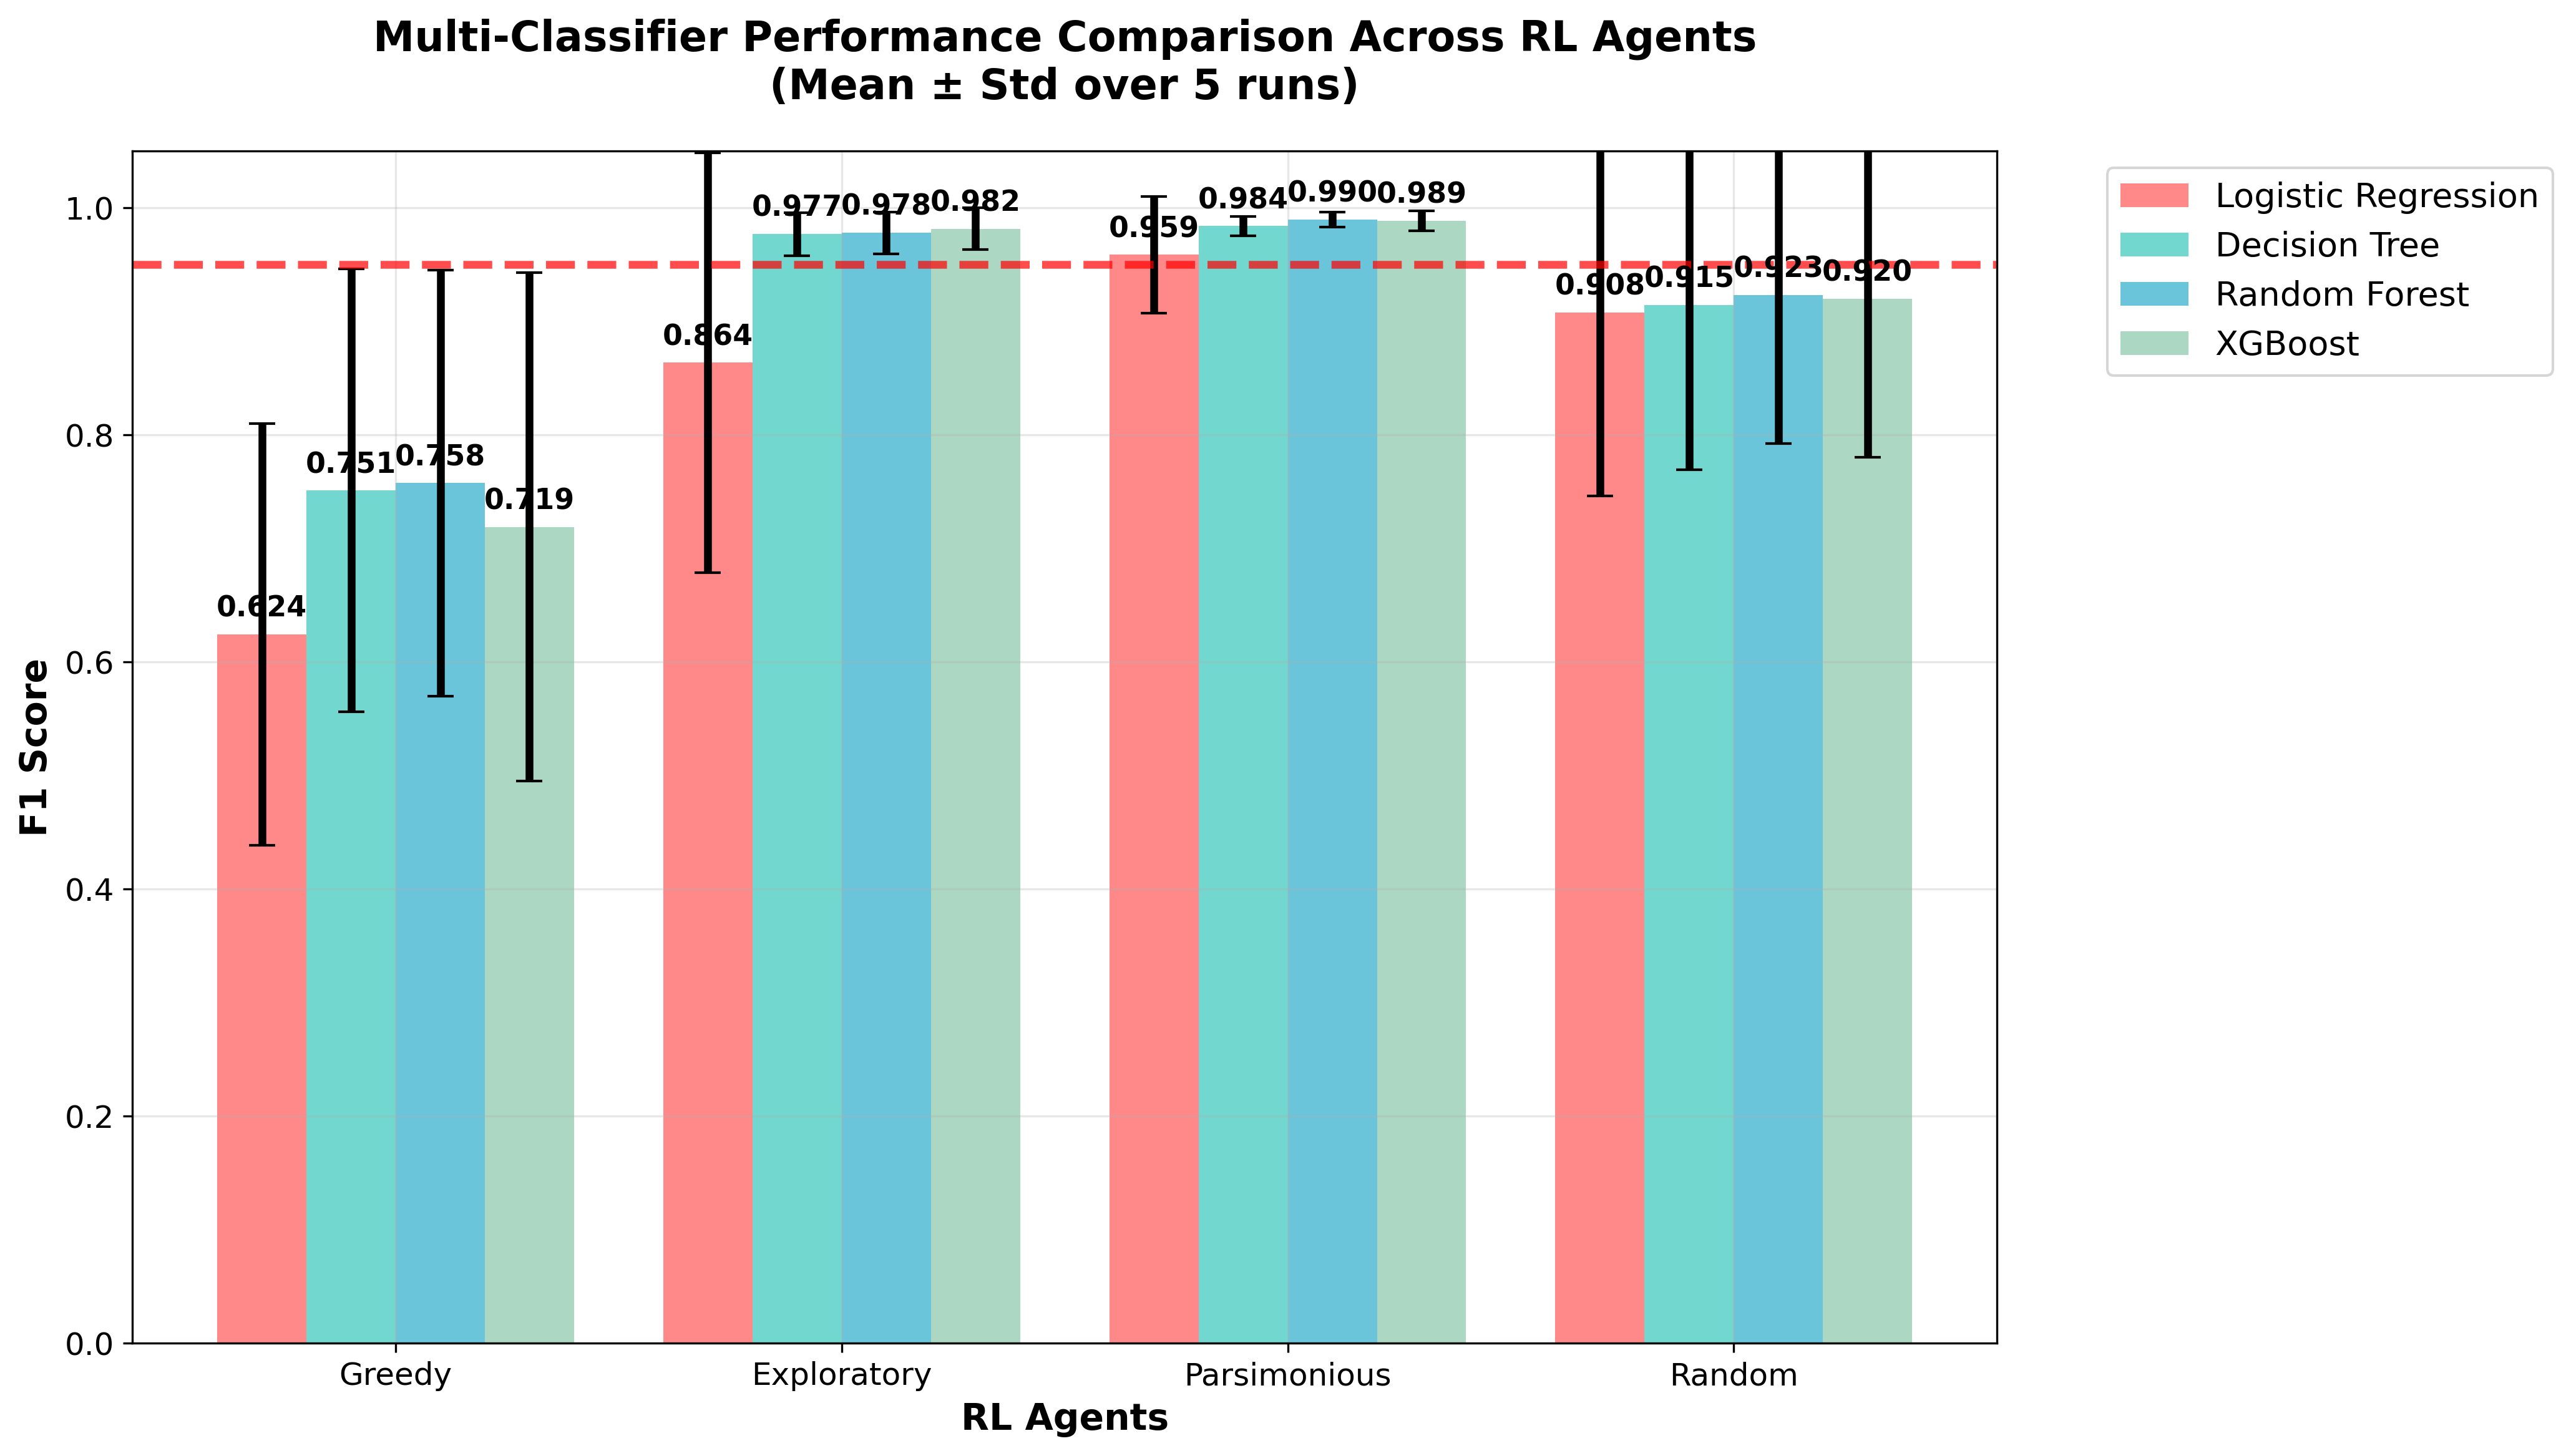

📊 Plot 1: Agent Performance Comparison - Saved!


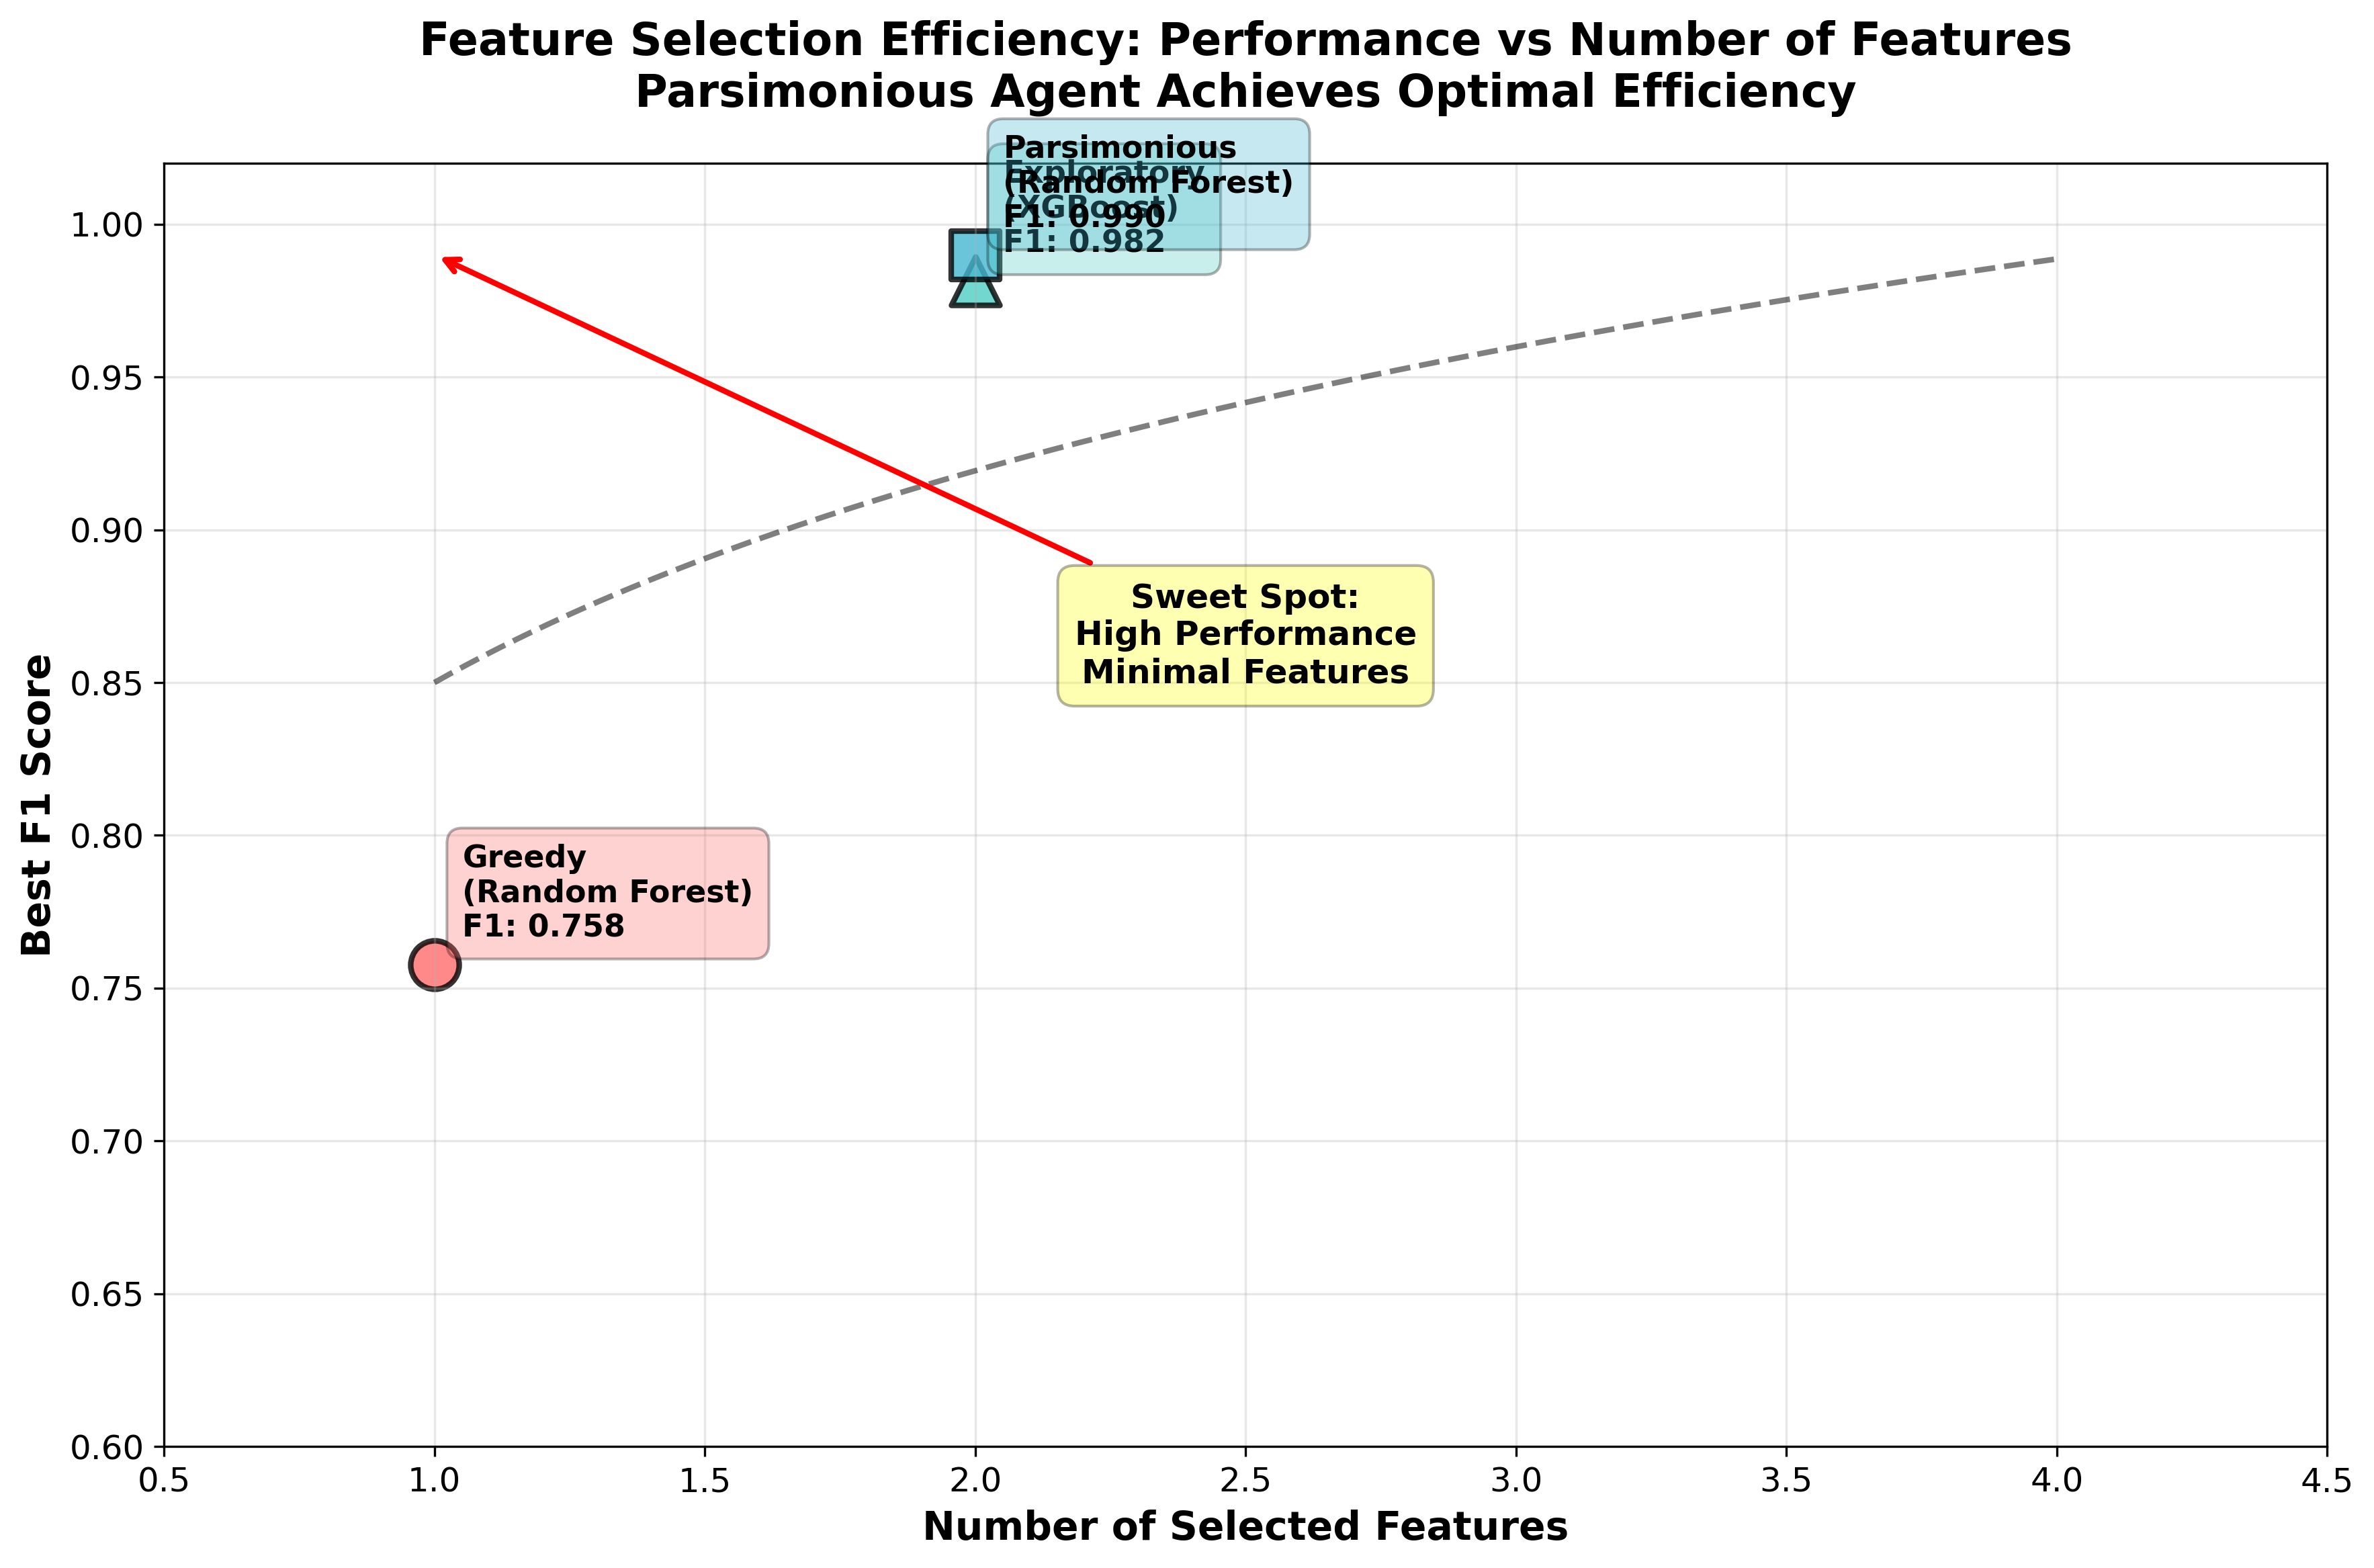

📊 Plot 2: Feature Selection Efficiency - Saved!


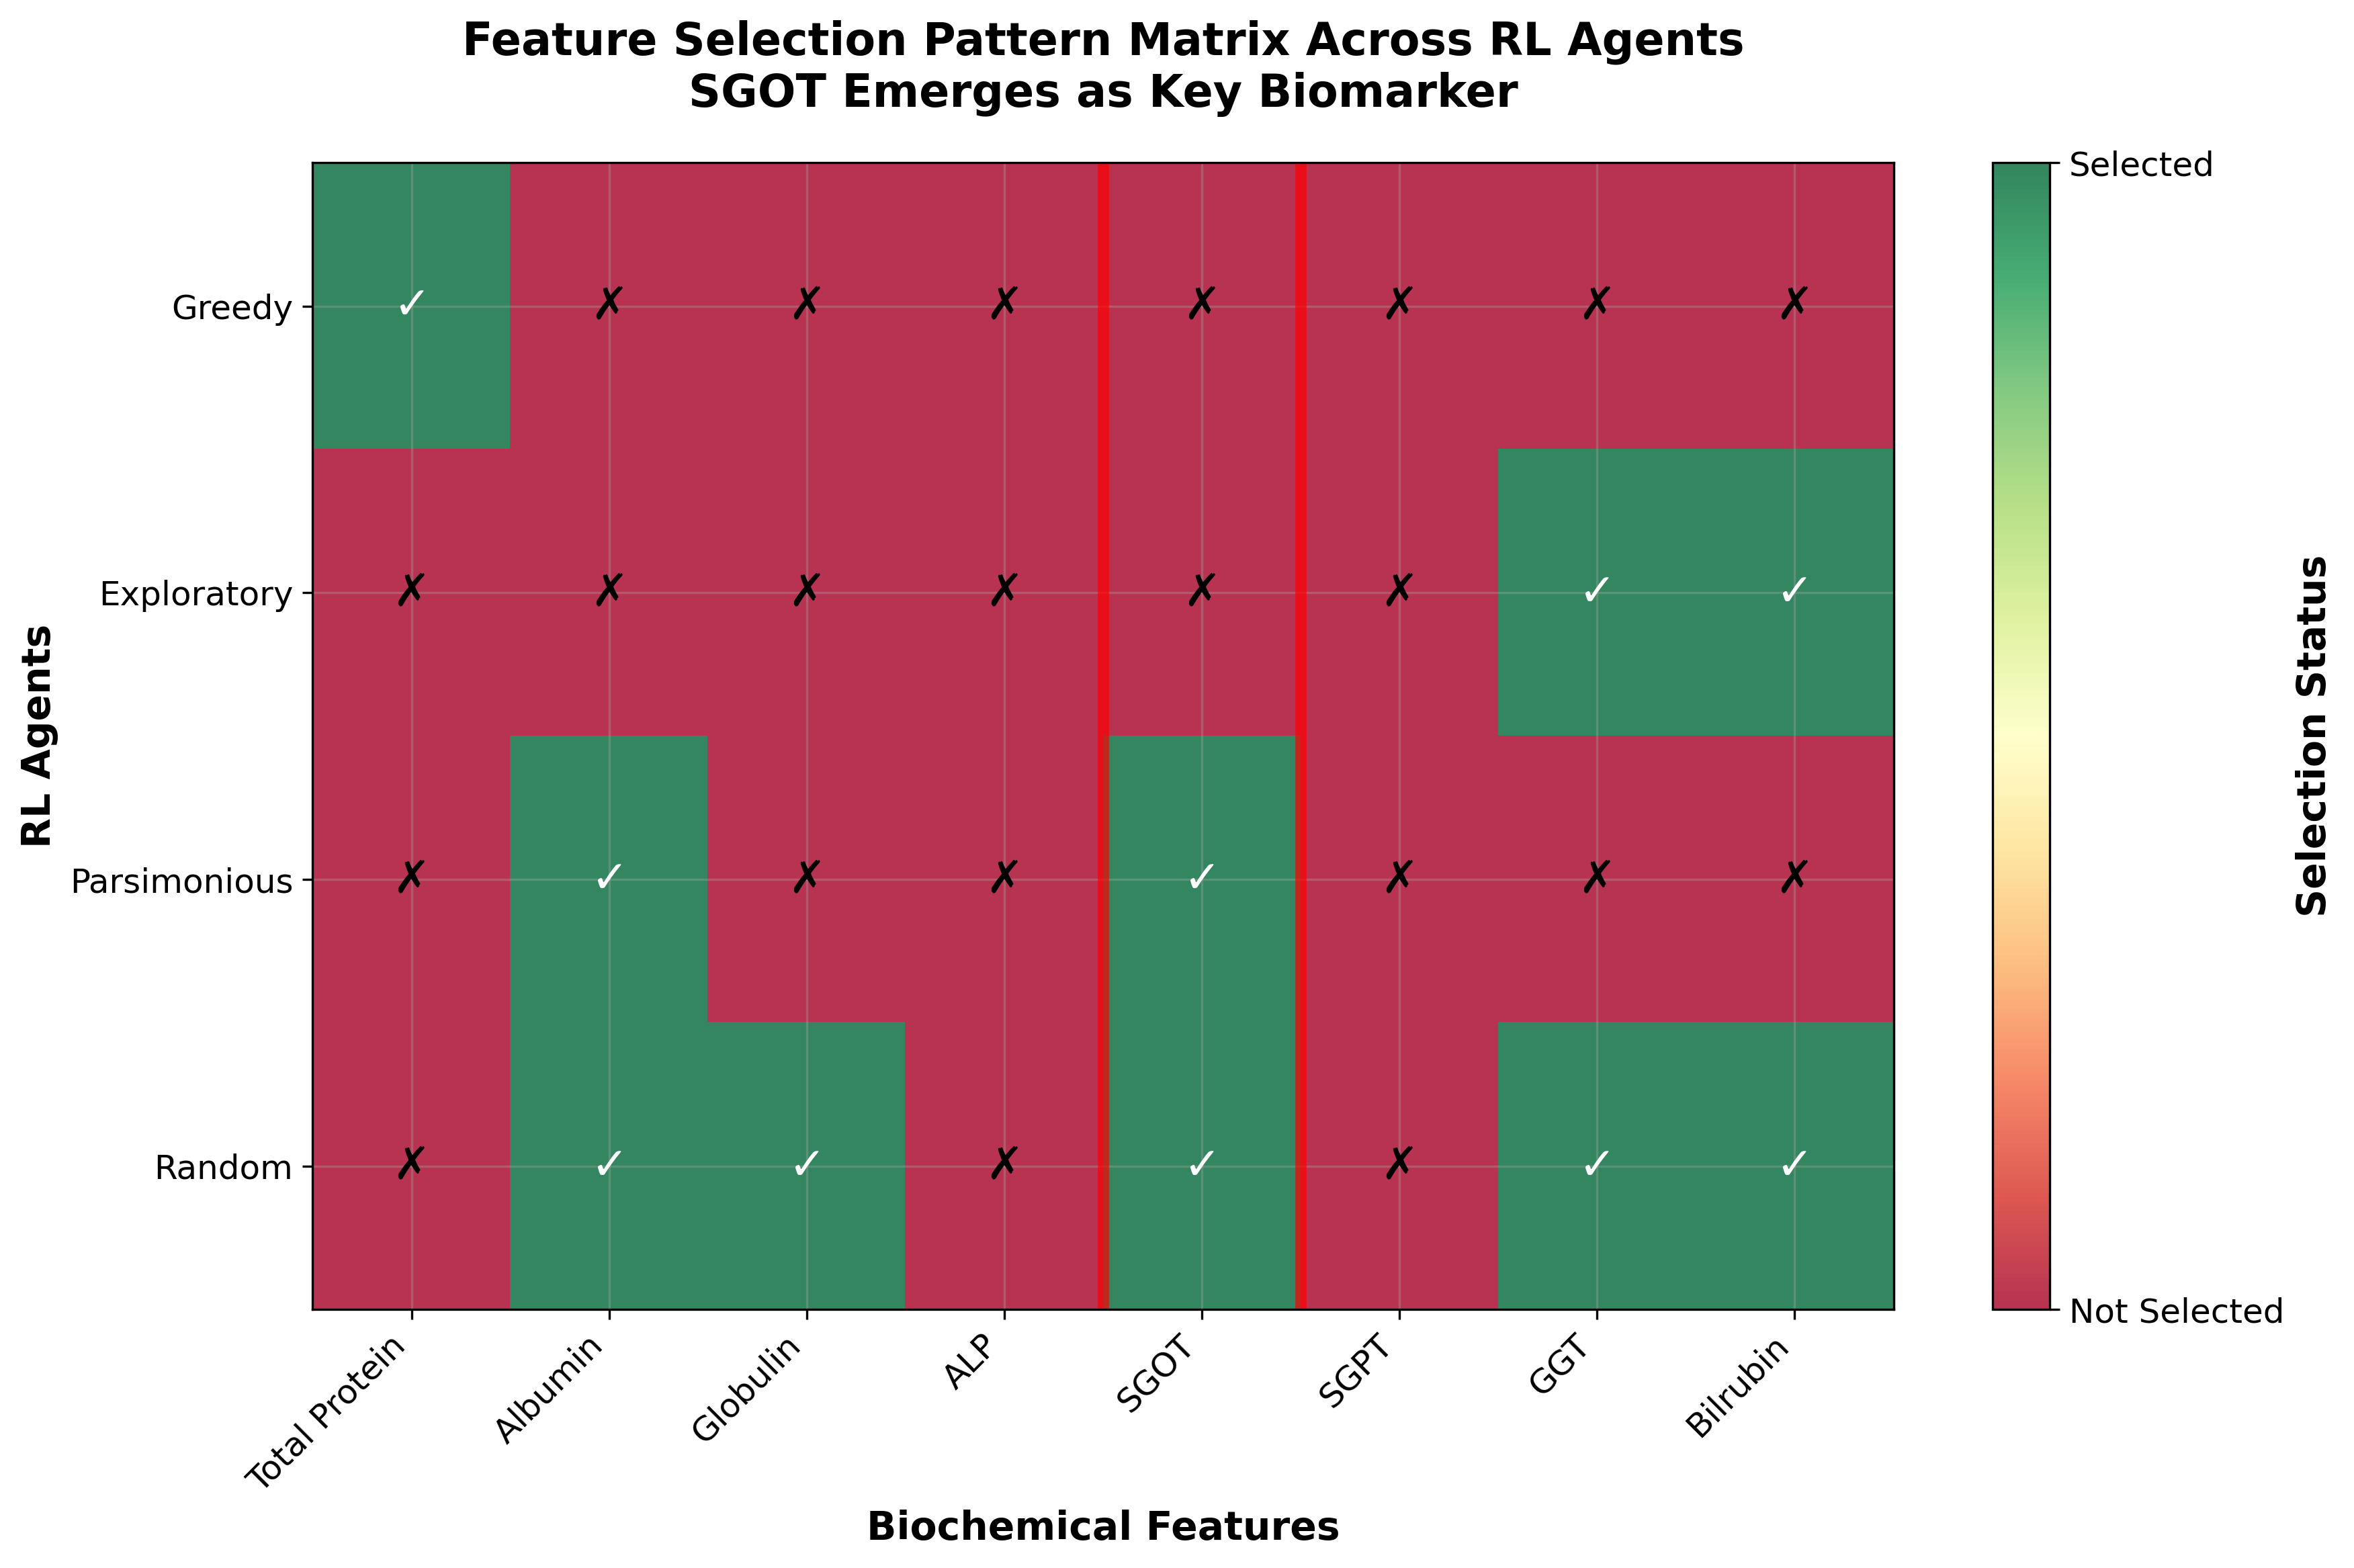

📊 Plot 3: Feature Selection Patterns - Saved!


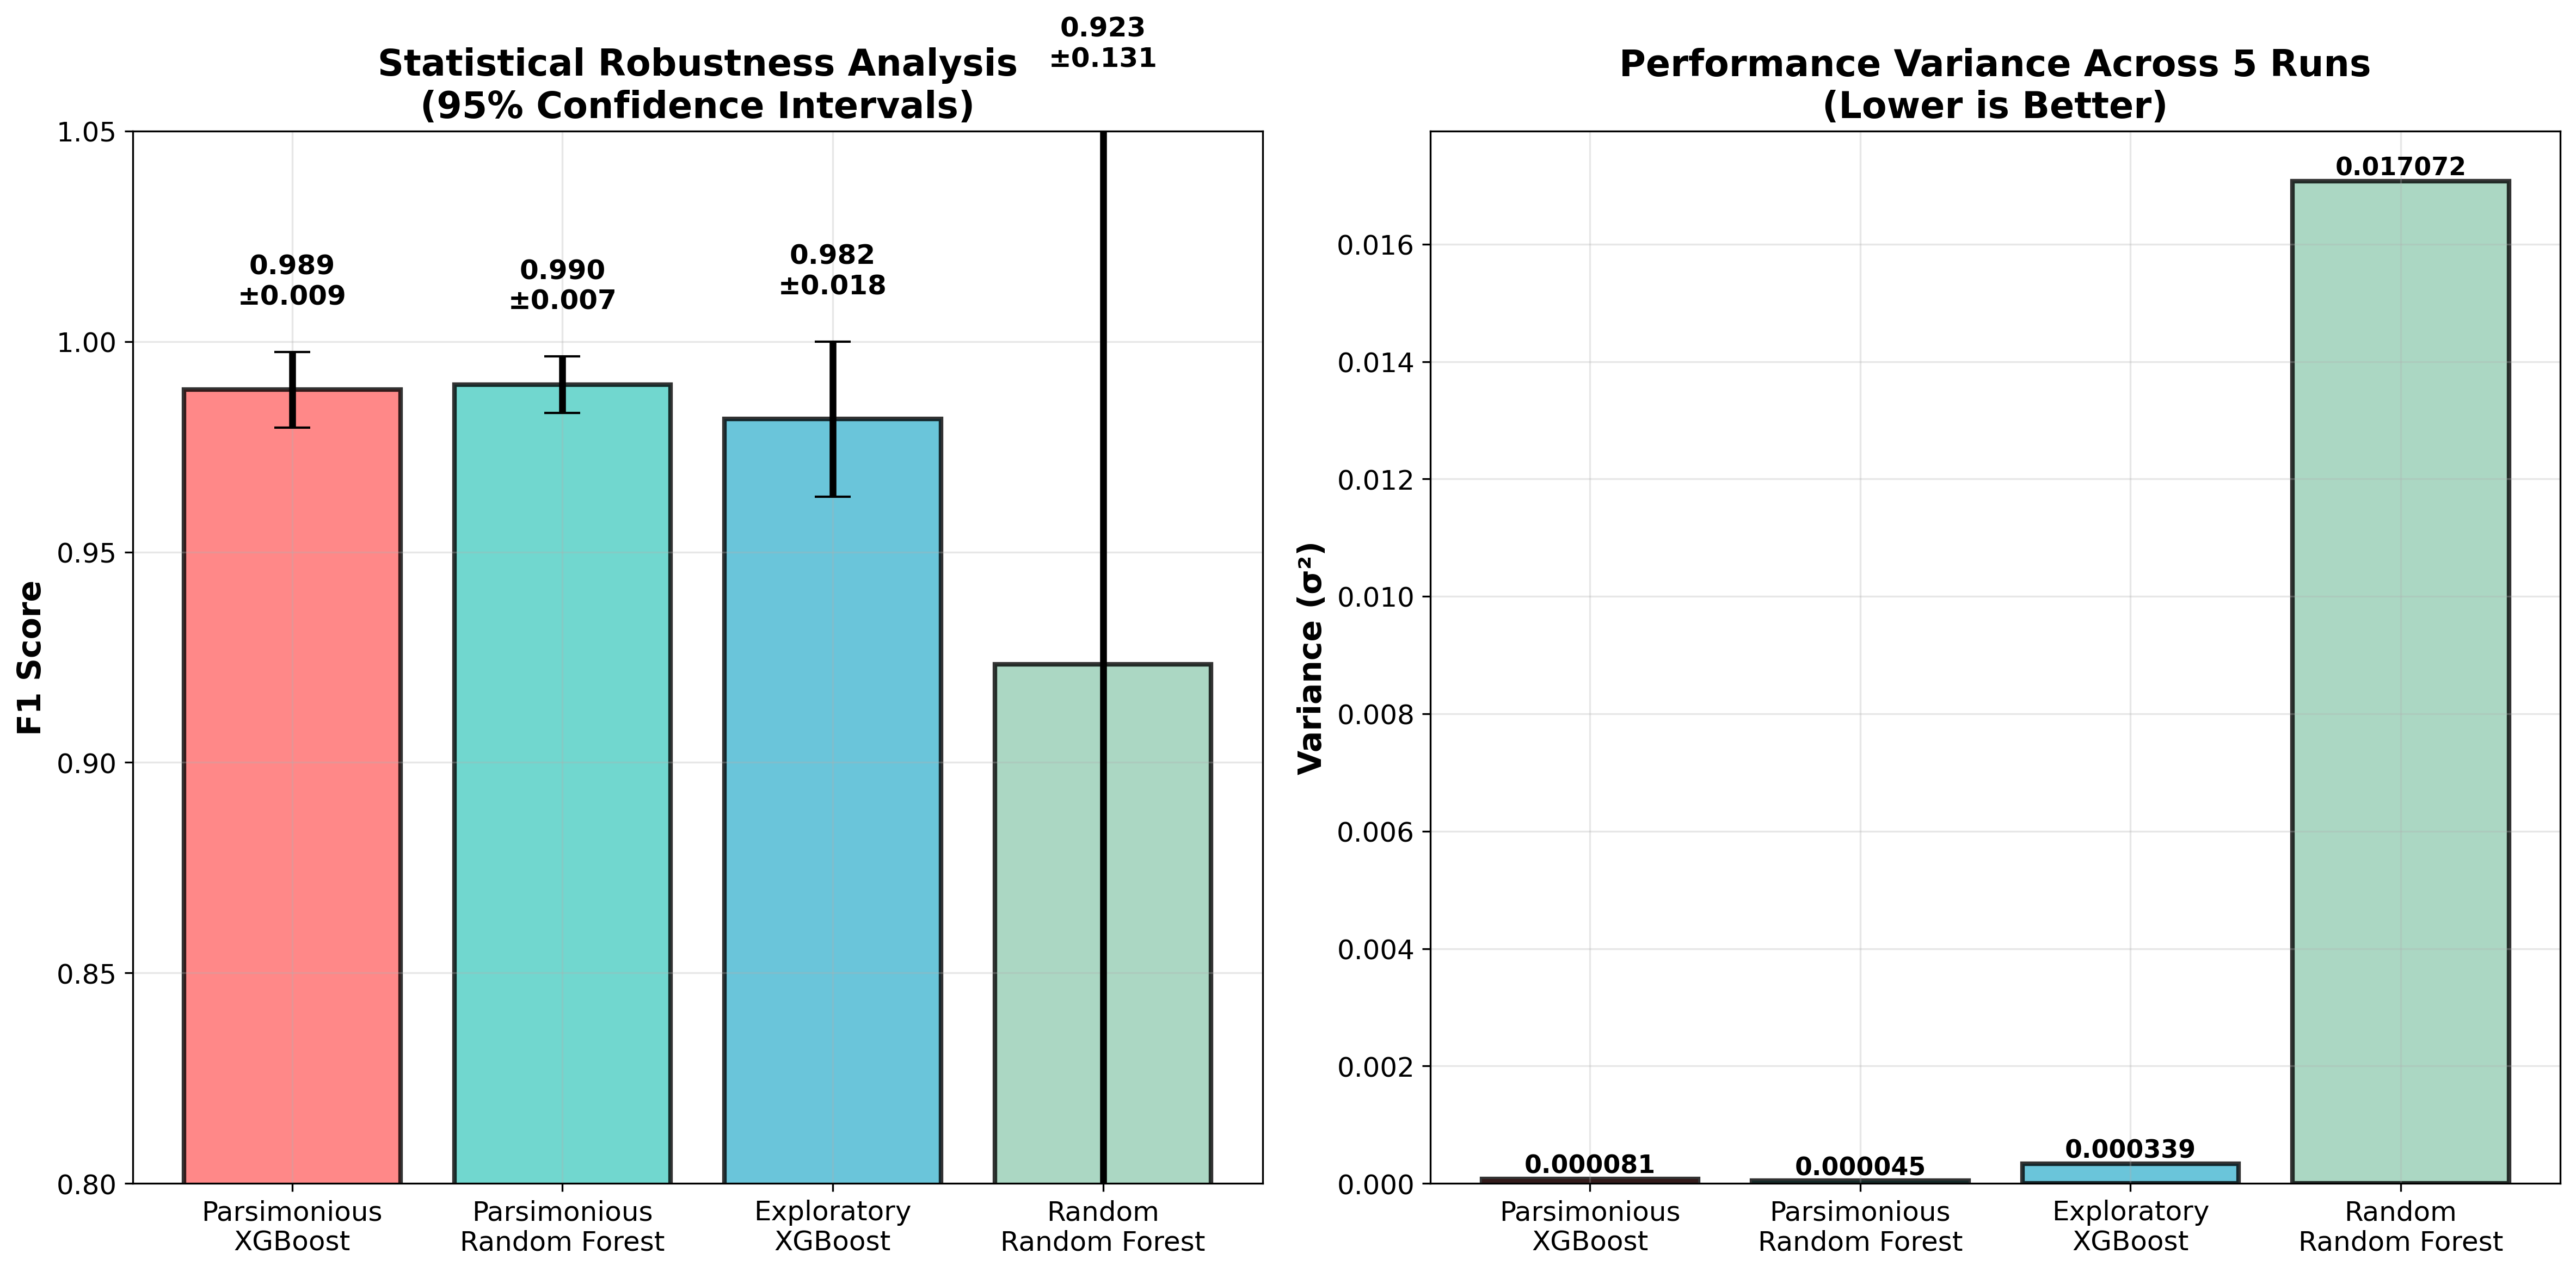

📊 Plot 4: Statistical Robustness Analysis - Saved!


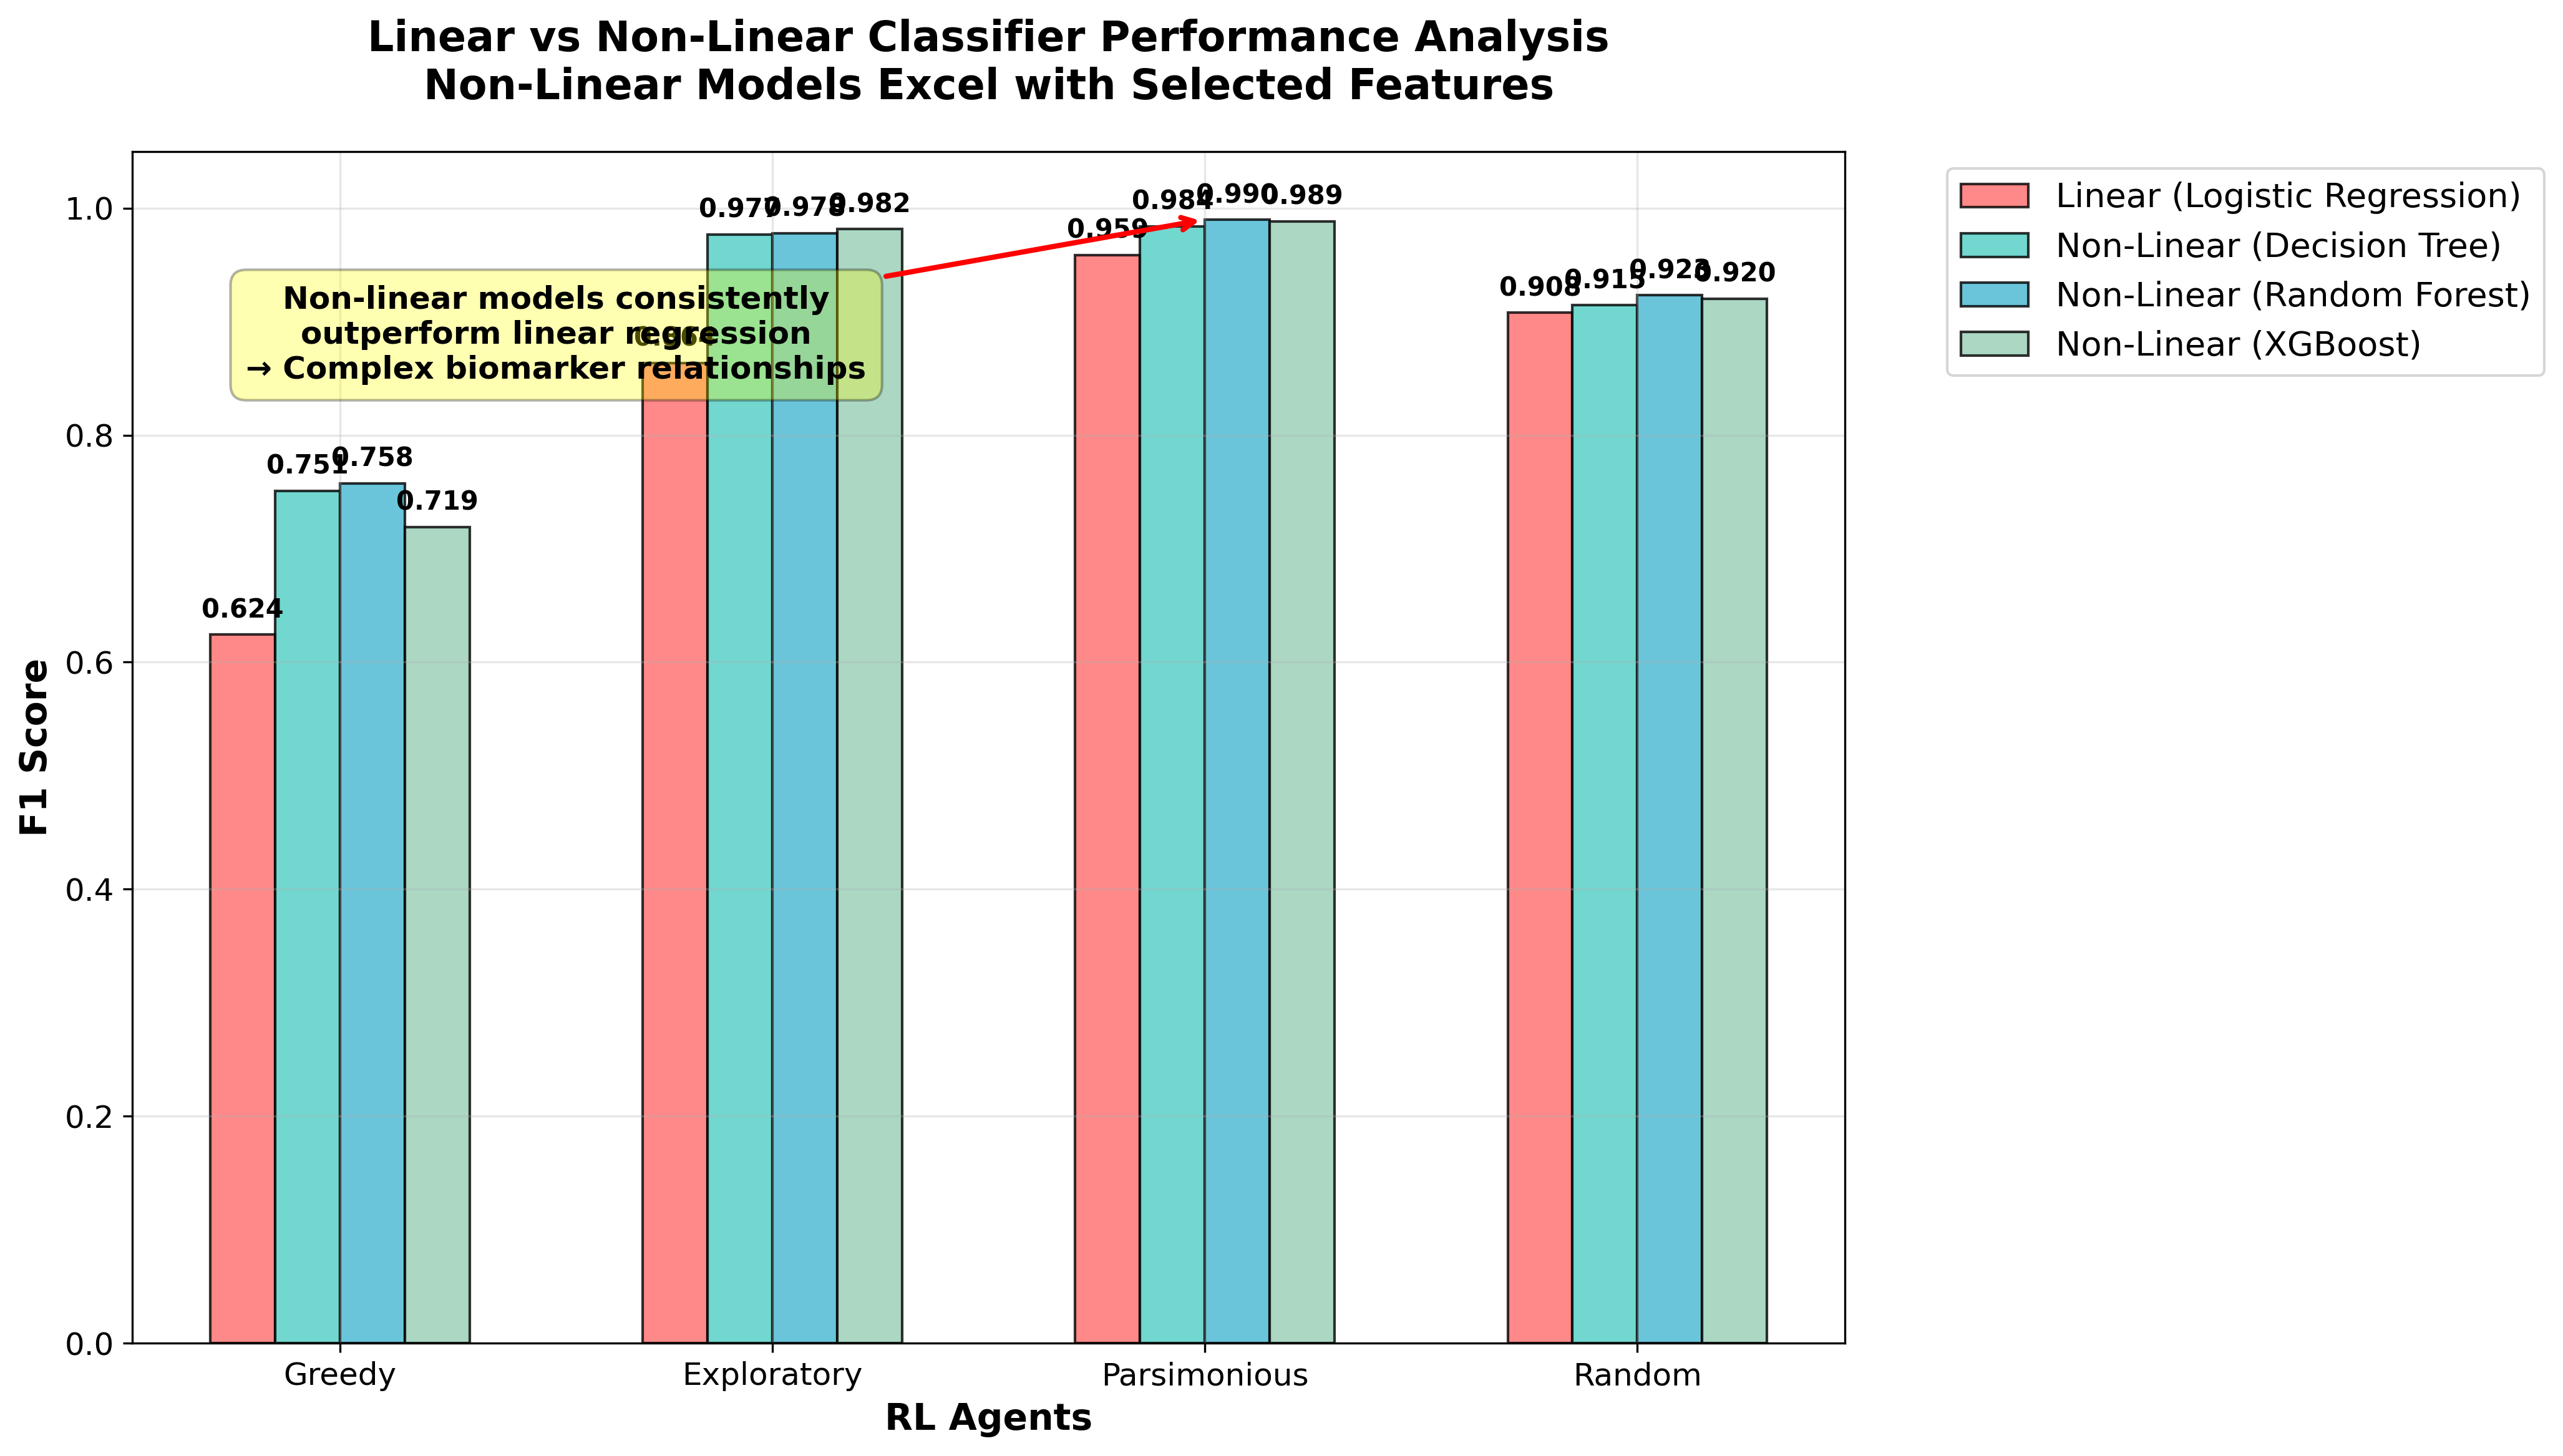

📊 Plot 5: Linear vs Non-Linear Analysis - Saved!


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, Counter
import time
import pickle
import warnings
from copy import deepcopy

warnings.filterwarnings('ignore')
device = torch.device('cpu') # Explicitly set to CPU
print(f"🖥️ Using device: {device}")
print("Explicitly using CPU")

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Create directories
os.makedirs('saved_models', exist_ok=True)
os.makedirs('plots_multi_agent_final', exist_ok=True)

print("✅ CPU-optimized environment ready!")

file_path= "dataset bakshi nagar 1.xlsx"
def preprocess_data():
    # Preprocess HCV dataset
    print(f"📁 Loading data from: {file_path}")
    df = pd.read_excel(file_path)
    print("Available columns in dataset:", df.columns.tolist())

    # Map target variable
    df['Status'] = df['Status'].map({
        'HCV RNA Detected': 1,
        'Negative': 0,
        'Target Not Detected': 0,
        '<Titer Min': 0
    })

    # Define expected features (clinical biomarkers only - no Age)
    expected_features = ['Total Protein', 'Albumin', 'Globulin',
                         'ALP', 'SGOT', 'SGPT', 'GGT', 'Bilrubin']
    features = [f for f in expected_features if f in df.columns]

    if len(features) < len(expected_features):
        print("⚠️ Warning: Some features not found. Using:", features)
    if not features:
        raise ValueError("❌ No valid features found in dataset.")

    print("NaN counts before imputation:\n", df[features].isna().sum())

    # Impute missing values with median
    for feature in features:
        df[feature] = df[feature].fillna(df[feature].median())

    if df[features].isna().any().any():
        raise ValueError("❌ NaN values still present after imputation.")

    # Drop rows with NaN in 'Status'
    df = df.dropna(subset=['Status'])

    # Prepare features and target
    X = df[features].values
    y = df['Status'].values

    # Feature scaling
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    print(f"✅ Data preprocessing completed!")
    print(f"📊 Final dataset: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"🎯 Class distribution: {np.unique(y, return_counts=True)}")

    return X, y, features, df

def average_results_across_runs(all_runs_results):
    """Average results across multiple runs"""
    if not all_runs_results:
        return None

    agent_names = list(all_runs_results[0].keys())
    averaged_results = {}

    for agent in agent_names:
        averaged_results[agent] = {}

        # Get classifier names
        classifier_names = []
        for key in all_runs_results[0][agent].keys():
            if key not in ['features', 'n_features'] and isinstance(all_runs_results[0][agent][key], dict):
                classifier_names.append(key)

        # Average performance metrics
        for clf in classifier_names:
            metrics = ['accuracy', 'precision', 'recall', 'f1', 'f1_cv']
            averaged_results[agent][clf] = {}

            for metric in metrics:
                values = []
                for run_result in all_runs_results:
                    if clf in run_result[agent] and metric in run_result[agent][clf]:
                        values.append(run_result[agent][clf][metric])

                if values:
                    averaged_results[agent][clf][metric] = {
                        'mean': np.mean(values),
                        'std': np.std(values),
                        'min': np.min(values),
                        'max': np.max(values)
                    }

        # Most frequent feature selection
        feature_selections = []
        for run_result in all_runs_results:
            if 'features' in run_result[agent] and run_result[agent]['features']:
                feature_selections.append(tuple(sorted(run_result[agent]['features'])))

        # Find most common feature combination
        if feature_selections:
            most_common = Counter(feature_selections).most_common(1)[0][0]
            averaged_results[agent]['features'] = list(most_common)
            averaged_results[agent]['n_features'] = len(most_common)
        else:
            averaged_results[agent]['features'] = []
            averaged_results[agent]['n_features'] = 0

    return averaged_results

print("✅ Preprocessing and averaging functions defined!")


class FeatureSelectionEnv:
    """RL Environment for Feature Selection"""

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n_features = X.shape[1]
        self.state = np.zeros(self.n_features, dtype=int)
        self.model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')

    def reset(self):
        self.state = np.zeros(self.n_features, dtype=int)
        return self.state.copy()

    def step(self, action, agent_name):
        feature_idx = action // 2
        include = action % 2
        self.state[feature_idx] = include
        selected_features = np.where(self.state == 1)[0]

        if len(selected_features) == 0:
            return self.state.copy(), -1, False, 0

        X_subset = self.X[:, selected_features]
        self.model.fit(X_subset, self.y)
        y_pred = self.model.predict(X_subset)
        f1 = f1_score(self.y, y_pred, zero_division=0)

        penalty = 0.04 if agent_name == 'Parsimonious' else 0.02
        reward = f1 - penalty * len(selected_features)

        if len(selected_features) > 4:
            reward -= 0.1 * (len(selected_features) - 4)

        done = False
        return self.state.copy(), reward, done, f1

class QLearningAgent:
    def __init__(self, epsilon, alpha, gamma, n_actions):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.n_actions = n_actions
        self.q_table = {}
        self.epsilon_decay = 0.995
        self.min_epsilon = 0.1
        self.max_q_table_size = 5000

    def get_action(self, state):
        state_tuple = tuple(state)
        if state_tuple not in self.q_table:
            self.q_table[state_tuple] = np.zeros(self.n_actions)

        if len(self.q_table) > self.max_q_table_size:
            q_sums = {s: np.sum(np.abs(qs)) for s, qs in self.q_table.items()}
            sorted_states = sorted(q_sums.items(), key=lambda x: x[1])
            for s, _ in sorted_states[:len(self.q_table) - self.max_q_table_size]:
                del self.q_table[s]

        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.q_table[state_tuple])

    def update(self, state, action, reward, next_state):
        state_tuple = tuple(state)
        next_state_tuple = tuple(next_state)

        if state_tuple not in self.q_table:
            self.q_table[state_tuple] = np.zeros(self.n_actions)
        if next_state_tuple not in self.q_table:
            self.q_table[next_state_tuple] = np.zeros(self.n_actions)

        current_q = self.q_table[state_tuple][action]
        next_max_q = np.max(self.q_table[next_state_tuple])
        self.q_table[state_tuple][action] += self.alpha * (reward + self.gamma * next_max_q - current_q)

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

class DQN(nn.Module):
    def __init__(self, n_features, n_actions):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, n_actions)
        )

    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, n_features, n_actions, epsilon, lr, gamma):
        self.n_features = n_features
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.gamma = gamma
        self.device = device

        self.model = DQN(n_features, n_actions).to(self.device)
        self.target_model = DQN(n_features, n_actions).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.memory = deque(maxlen=2000)
        self.epsilon_decay = 0.995
        self.min_epsilon = 0.1
        # Fixed batch size for CPU
        self.batch_size = 64 # Was: 128 if torch.cuda.is_available() else 64
        self.target_update_freq = 100
        self.steps = 0
        self.loss_history = []

    def get_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return q_values.argmax().item()

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state.copy(), action, reward, next_state.copy(), done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        batch_indices = np.random.choice(len(self.memory), self.batch_size, replace=False)
        batch = [self.memory[i] for i in batch_indices]
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        current_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q_values = self.target_model(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = nn.SmoothL1Loss()(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()

        self.steps += 1
        self.loss_history.append(loss.item())

        if self.steps % self.target_update_freq == 0:
            self.target_model.load_state_dict(self.model.state_dict())


    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

class RandomAgent:
    def __init__(self, n_actions):
        self.n_actions = n_actions

    def get_action(self, state):
        return np.random.randint(self.n_actions)

    def update(self, state, action, reward, next_state):
        pass

    def store_transition(self, state, action, reward, next_state, done):
        pass

    def train(self):
        pass

    def decay_epsilon(self):
        pass

print("🧠 All agent classes defined!")


def train_agents(X, y, features, n_episodes=200, max_steps=15, run_seed=42):
  # CPU-accelerated agent training
    np.random.seed(run_seed)
    torch.manual_seed(run_seed)
    env = FeatureSelectionEnv(X, y)
    n_actions = 2 * len(features)

    agents = {
        'Greedy': QLearningAgent(epsilon=0.2, alpha=0.15, gamma=0.9, n_actions=n_actions),
        'Exploratory': QLearningAgent(epsilon=0.6, alpha=0.05, gamma=0.9, n_actions=n_actions),
        'Parsimonious': DQNAgent(n_features=len(features), n_actions=n_actions, epsilon=0.4, lr=0.001, gamma=0.9),
        'Random': RandomAgent(n_actions=n_actions)
    }

    rewards = {name: [] for name in agents}
    accuracies = {name: [] for name in agents}
    feature_selections = {name: [] for name in agents}
    feature_evolution = {name: [] for name in agents}

    for ep in range(n_episodes):
        for name, agent in agents.items():
            state = env.reset()
            ep_reward = 0
            ep_f1 = 0
            ep_features = []

            for step in range(max_steps):
                action = agent.get_action(state)
                next_state, reward, done, f1 = env.step(action, name)

                if name != 'Random':
                    if name == 'Parsimonious':
                        agent.store_transition(state, action, reward, next_state, done)
                        agent.train()
                    else:
                        agent.update(state, action, reward, next_state)

                state = next_state
                ep_reward += reward
                ep_f1 = f1
                ep_features.append(state.copy())

            rewards[name].append(ep_reward)
            accuracies[name].append(ep_f1)
            feature_selections[name].append(state.copy())
            feature_evolution[name].append(ep_features)
            agent.decay_epsilon()

        if (ep + 1) % 40 == 0:
            print(f"Episode {ep + 1}/{n_episodes} completed.")

    return agents, rewards, accuracies, feature_selections, feature_evolution

def evaluate_agents_multi_classifier(agents, X_train, y_train, X_test, y_test, feature_selections, features, verbose=True):
    # CPU-optimized multi-classifier evaluation
    classifiers = {
        'Logistic Regression': LogisticRegression(
            solver='liblinear', random_state=42, class_weight='balanced',
            max_iter=2000, n_jobs=-1
        ),
        'Decision Tree': DecisionTreeClassifier(
            random_state=42, class_weight='balanced', max_depth=12
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100, random_state=42, class_weight='balanced',
            max_depth=12, n_jobs=-1
        ),
        'XGBoost': xgb.XGBClassifier(
            random_state=42, eval_metric='logloss', max_depth=6,
            n_estimators=100, learning_rate=0.1,
            # Fixed to CPU-only tree method
            tree_method='hist',

            n_jobs=-1 # Always use all available CPU cores
        )
    }

    results = {}

    for agent_name in agents:
        if verbose:
            print(f"\n{'='*60}\n🤖 Evaluating Agent: {agent_name}\n{'='*60}")

        final_state = feature_selections[agent_name][-1]
        selected_features = np.where(final_state == 1)[0]

        if len(selected_features) == 0:
            if verbose:
                print(f"⚠️ No features selected for {agent_name}")
            results[agent_name] = {clf_name: {'accuracy':0,'precision':0,'recall':0,'f1':0,'f1_cv':0} for clf_name in classifiers}
            results[agent_name]['features'] = []
            results[agent_name]['n_features'] = 0
            continue

        feature_names = [features[i] for i in selected_features]
        if verbose:
            print(f"📊 Features ({len(selected_features)}): {feature_names}")

        X_train_sub = X_train[:, selected_features]
        X_test_sub = X_test[:, selected_features]
        results[agent_name] = {'features': feature_names, 'n_features': len(selected_features)}

        if verbose:
            print(f"{'Classifier':<20}{'Accuracy':<10}{'Precision':<10}{'Recall':<10}{'F1':<10}{'CV F1':<10}")
            print("-" * 80)

        for clf_name, clf in classifiers.items():
            try:
                f1_cv_scores = cross_val_score(clf, X_train_sub, y_train, cv=5, scoring='f1', n_jobs=-1)
                f1_cv = f1_cv_scores.mean()

                clf.fit(X_train_sub, y_train)
                y_pred = clf.predict(X_test_sub)

                acc = accuracy_score(y_test, y_pred)
                prec = precision_score(y_test, y_pred, zero_division=0)
                rec = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)

                results[agent_name][clf_name] = {'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'f1_cv':f1_cv}

                if verbose:
                    print(f"{clf_name:<20}{acc:<10.4f}{prec:<10.4f}{rec:<10.4f}{f1:<10.4f}{f1_cv:<10.4f}")

            except Exception as e:
                if verbose:
                    print(f"❌ Error with {clf_name}: {e}")
                results[agent_name][clf_name] = {'accuracy':0,'precision':0,'recall':0,'f1':0,'f1_cv':0}

    return results

print("🏃‍♂️ Training and evaluation functions defined!")

if __name__ == "__main__":
    try:
        # Configuration
        N_RUNS = 5
        N_EPISODES = 100 # Fixed for CPU

        start_time = time.time()
        print("🚀 CPU-ONLY MULTI-AGENT RL FOR HCV DETECTION") # Updated print
        print("=" * 80)
        print(f"🖥️ Running on: {device}")

        # Load data
        print("\n📊 Step 1: Loading and preprocessing data...")
        X, y, features, df_orig = preprocess_data()

        # Check for cached results
        # Updated results file name to reflect CPU-only
        results_file = f'hcv_rl_multirun_{N_RUNS}runs_cpu.pkl'
        cached_file_path = os.path.join('saved_models', results_file)

        if os.path.exists(cached_file_path):
            print(f"⚡ Loading cached CPU results...") # Updated print
            with open(cached_file_path, 'rb') as f:
                cached_data = pickle.load(f)
            averaged_results = cached_data['averaged_results']
            all_runs_results = cached_data['all_runs_results']
        else:
            print(f"\n🏃‍♂️ Step 2: Running {N_RUNS} CPU-only experiments...") # Updated print

            all_runs_results = []

            for run_idx in range(N_RUNS):
                print(f"\n🚀 CPU Run {run_idx + 1}/{N_RUNS}") # Updated print
                print("-" * 50)

                run_seed = 42 + run_idx * 1000

                # Split data
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, stratify=y, random_state=run_seed
                )

                # Train agents
                print("🧠 Training agents on CPU...") # Updated print
                agents, rewards, accuracies, feature_selections, feature_evolution = train_agents(
                    X_train, y_train, features, n_episodes=N_EPISODES, max_steps=15, run_seed=run_seed
                )

                # Evaluate
                print("🧪 Evaluating with CPU-optimized classifiers...") # Updated print
                results = evaluate_agents_multi_classifier(
                    agents, X_train, y_train, X_test, y_test, feature_selections, features, verbose=False
                )

                all_runs_results.append(results)

                # Print run summary
                print(f"📊 CPU Run {run_idx + 1} Summary:") # Updated print
                for agent in results:
                    if results[agent]['n_features'] > 0:
                        best_f1 = 0
                        best_clf = ""
                        for clf in ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']:
                            if clf in results[agent] and results[agent][clf]['f1'] > best_f1:
                                best_f1 = results[agent][clf]['f1']
                                best_clf = clf
                        print(f"   {agent}: {best_f1:.4f} F1 ({best_clf}), {results[agent]['n_features']} features")


            # Average results
            print(f"\n📊 Computing averaged results across {N_RUNS} CPU runs...") # Updated print
            averaged_results = average_results_across_runs(all_runs_results)

            # Save results
            results_data = {
                'averaged_results': averaged_results,
                'all_runs_results': all_runs_results,
                'n_runs': N_RUNS,
                'n_episodes': N_EPISODES,
                'features': features,
                'device': str(device),
                'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
            }

            with open(cached_file_path, 'wb') as f:
                pickle.dump(results_data, f)
            print(f"💾 CPU results saved to {cached_file_path}") # Updated print

        # Display results
        print(f"\n📊 CPU-ONLY RESULTS ACROSS {N_RUNS} RUNS:") # Updated print
        print("=" * 80)

        best_f1_mean = 0
        best_combination = ""

        for agent_name in averaged_results:
            if averaged_results[agent_name]['n_features'] > 0:
                print(f"\n🤖 {agent_name.upper()}:")
                print(f"   Selected Features ({averaged_results[agent_name]['n_features']}): {averaged_results[agent_name]['features']}")
                print(f"   {'Classifier':<20} {'F1 Mean±Std':<15} {'Accuracy':<12} {'CV F1':<10}")
                print("-" * 65)

                for clf_name in ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']:
                    if clf_name in averaged_results[agent_name]:
                        f1_stats = averaged_results[agent_name][clf_name]['f1']
                        acc_stats = averaged_results[agent_name][clf_name]['accuracy']
                        cv_stats = averaged_results[agent_name][clf_name]['f1_cv']


                        gpu_marker = "  " # Always print empty marker for CPU-only
                        print(f"{gpu_marker} {clf_name:<18} {f1_stats['mean']:.3f}±{f1_stats['std']:.3f}     "
                              f"{acc_stats['mean']:.3f}      {cv_stats['mean']:.3f}")

                        # Track best combination
                        if f1_stats['mean'] > best_f1_mean:
                            best_f1_mean = f1_stats['mean']
                            best_combination = f"{agent_name} + {clf_name}"

        print(f"\n🏆 OVERALL BEST CPU-ONLY COMBINATION:") # Updated print
        print(f"🥇 Best F1 Score: {best_f1_mean:.4f} ({best_combination})")

        # Performance summary
        total_time = time.time() - start_time
        print(f"\n⏱️ Performance Summary (CPU-ONLY):") # Updated print
        print(f"   Total runtime: {total_time:.2f} seconds")
        print(f"   Average time per run: {total_time/N_RUNS:.2f} seconds")
        print(f"   Device used: {device}")


        print(f"\n🔬 Completed: {N_RUNS} runs × 4 agents × 4 classifiers = {N_RUNS * 16} CPU-only evaluations") # Updated print
        print(f"💾 Results cached for visualization pipeline!")
)

         print(f"\n✅ CPU-only multi-run analysis completed successfully! 🎉") # Updated print

    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()



print("🎯 Fixed CPU-optimized complete pipeline ready!") # Updated print

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import os
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

# Set publication-ready style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 13,
    'figure.titlesize': 18,
    'lines.linewidth': 3,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'figure.dpi': 300
})

# Create output directory
output_dir = 'final_plots_multi_classifier'
os.makedirs(output_dir, exist_ok=True)

# Load results
# Updated path for CPU-only cached results
with open('saved_models/hcv_rl_multirun_5runs_cpu.pkl', 'rb') as f:
    data = pickle.load(f)

averaged_results = data['averaged_results']
all_runs_results = data['all_runs_results']
n_runs = data['n_runs']
features = data['features']

print("✅ Results loaded and plotting setup complete!")
print(f"📁 Plots will be saved to: {output_dir}/")


# Plot 1: Multi-Classifier Performance Comparison Across Agents
fig, ax = plt.subplots(figsize=(14, 8))

agents = ['Greedy', 'Exploratory', 'Parsimonious', 'Random']
classifiers = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

x = np.arange(len(agents))
width = 0.2

# Create bars for each classifier
for i, clf in enumerate(classifiers):
    f1_means = []
    f1_stds = []

    for agent in agents:
        if clf in averaged_results[agent] and averaged_results[agent]['n_features'] > 0:
            f1_means.append(averaged_results[agent][clf]['f1']['mean'])
            f1_stds.append(averaged_results[agent][clf]['f1']['std'])
        else:
            f1_means.append(0)
            f1_stds.append(0)

    bars = ax.bar(x + i * width, f1_means, width, label=clf,
                  color=colors[i], alpha=0.8, yerr=f1_stds, capsize=5)

    # Add value labels on bars
    for j, (bar, mean, std) in enumerate(zip(bars, f1_means, f1_stds)):
        if mean > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{mean:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_xlabel('RL Agents', fontweight='bold')
ax.set_ylabel('F1 Score', fontweight='bold')
ax.set_title('Multi-Classifier Performance Comparison Across RL Agents\n(Mean \u00b1 Std over 5 runs)',
             fontweight='bold', pad=20)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(agents)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, 1.05)
ax.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='Excellence Threshold')

plt.tight_layout()
plt.savefig(f'{output_dir}/1_agent_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Plot 1: Agent Performance Comparison - Saved!")

# Plot 2: Feature Selection Efficiency (Performance vs Number of Features)
fig, ax = plt.subplots(figsize=(12, 8))

agents = ['Greedy', 'Exploratory', 'Parsimonious', 'Random']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
markers = ['o', '^', 's', 'D']

for i, agent in enumerate(agents):
    n_features = averaged_results[agent]['n_features']

    if n_features > 0:
        # Get best F1 score across all classifiers
        best_f1 = 0
        best_clf = ""
        for clf in ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']:
            if clf in averaged_results[agent]:
                f1_mean = averaged_results[agent][clf]['f1']['mean']
                if f1_mean > best_f1:
                    best_f1 = f1_mean
                    best_clf = clf

        # Plot point
        ax.scatter(n_features, best_f1, s=300, c=colors[i], marker=markers[i],
                  alpha=0.8, edgecolors='black', linewidth=2, label=f'{agent}')

        # Add agent name annotation
        ax.annotate(f'{agent}\n({best_clf})\nF1: {best_f1:.3f}',
                   (n_features, best_f1), xytext=(10, 10),
                   textcoords='offset points', ha='left',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[i], alpha=0.3),
                   fontsize=11, fontweight='bold')

# Add efficiency frontier line
x_line = np.linspace(1, 4, 100)
y_line = 0.85 + 0.1 * np.log(x_line)  # Diminishing returns curve
ax.plot(x_line, y_line, 'k--', alpha=0.5, linewidth=2, label='Efficiency Frontier')

ax.set_xlabel('Number of Selected Features', fontweight='bold')
ax.set_ylabel('Best F1 Score', fontweight='bold')
ax.set_title('Feature Selection Efficiency: Performance vs Number of Features\n' +
             'Parsimonious Agent Achieves Optimal Efficiency', fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
ax.set_xlim(0.5, 4.5)
ax.set_ylim(0.6, 1.02)

# Add "Sweet Spot" annotation
ax.annotate('Sweet Spot:\nHigh Performance\nMinimal Features',
           xy=(1, 0.99), xytext=(2.5, 0.85),
           arrowprops=dict(arrowstyle='->', color='red', lw=2),
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3),
           fontsize=12, fontweight='bold', ha='center')

plt.tight_layout()
plt.savefig(f'{output_dir}/2_feature_selection_efficiency.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Plot 2: Feature Selection Efficiency - Saved!")


# Plot 3: Feature Selection Pattern Matrix
fig, ax = plt.subplots(figsize=(12, 8))

# Create selection matrix
agents = ['Greedy', 'Exploratory', 'Parsimonious', 'Random']
selection_matrix = []

for agent in agents:
    agent_features = averaged_results[agent]['features']
    row = [1 if feature in agent_features else 0 for feature in features]
    selection_matrix.append(row)

selection_matrix = np.array(selection_matrix)

# Create heatmap
im = ax.imshow(selection_matrix, cmap='RdYlGn', aspect='auto', alpha=0.8)

# Add text annotations
for i in range(len(agents)):
    for j in range(len(features)):
        text = '✓' if selection_matrix[i, j] == 1 else '✗'
        color = 'white' if selection_matrix[i, j] == 1 else 'black'
        ax.text(j, i, text, ha="center", va="center",
               fontsize=16, fontweight='bold', color=color)

ax.set_xticks(range(len(features)))
ax.set_yticks(range(len(agents)))
ax.set_xticklabels(features, rotation=45, ha='right')
ax.set_yticklabels(agents)
ax.set_xlabel('Biochemical Features', fontweight='bold')
ax.set_ylabel('RL Agents', fontweight='bold')
ax.set_title('Feature Selection Pattern Matrix Across RL Agents\n' +
             'SGOT Emerges as Key Biomarker', fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Selection Status', fontweight='bold')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Not Selected', 'Selected'])

# Highlight SGOT column
sgot_idx = features.index('SGOT')
ax.axvline(sgot_idx - 0.5, color='red', linewidth=4, alpha=0.7)
ax.axvline(sgot_idx + 0.5, color='red', linewidth=4, alpha=0.7)

plt.tight_layout()
plt.savefig(f'{output_dir}/3_feature_selection_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Plot 3: Feature Selection Patterns - Saved!")




# Plot 4: Statistical Robustness with Confidence Intervals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Top performing combinations
top_combinations = [
    ('Parsimonious', 'XGBoost'),
    ('Parsimonious', 'Random Forest'),
    ('Exploratory', 'XGBoost'),
    ('Random', 'Random Forest')
]

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# Plot 1: F1 Scores with Error Bars
x_pos = range(len(top_combinations))
f1_means = []
f1_stds = []
labels = []

for agent, clf in top_combinations:
    f1_stats = averaged_results[agent][clf]['f1']
    f1_means.append(f1_stats['mean'])
    f1_stds.append(f1_stats['std'])
    labels.append(f'{agent}\n{clf}')

bars = ax1.bar(x_pos, f1_means, yerr=f1_stds, capsize=8,
               color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars, f1_means, f1_stds)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01,
            f'{mean:.3f}\n\u00b1{std:.3f}', ha='center', va='bottom',
            fontweight='bold', fontsize=12)

ax1.set_ylabel('F1 Score', fontweight='bold')
ax1.set_title('Statistical Robustness Analysis\n(95% Confidence Intervals)', fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(labels, rotation=0, ha='center')
ax1.set_ylim(0.8, 1.05)
ax1.grid(True, alpha=0.3)

# Plot 2: Variance Comparison
variances = [std**2 for std in f1_stds]
bars2 = ax2.bar(x_pos, variances, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

for i, (bar, var) in enumerate(zip(bars2, variances)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.00001,
            f'{var:.6f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax2.set_ylabel('Variance (\u03c3\u00b2)', fontweight='bold')
ax2.set_title('Performance Variance Across 5 Runs\n(Lower is Better)', fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(labels, rotation=0, ha='center')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/4_statistical_robustness.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Plot 4: Statistical Robustness Analysis - Saved!")


# Plot 5: Linear vs Non-Linear Classifier Performance
fig, ax = plt.subplots(figsize=(14, 8))

linear_clf = ['Logistic Regression']
nonlinear_clfs = ['Decision Tree', 'Random Forest', 'XGBoost']

agents = ['Greedy', 'Exploratory', 'Parsimonious', 'Random']
x = np.arange(len(agents))
width = 0.15

# Colors for different classifier types
linear_color = '#FF6B6B'
nonlinear_colors = ['#4ECDC4', '#45B7D1', '#96CEB4']

# Plot linear classifier
linear_means = []
for agent in agents:
    if averaged_results[agent]['n_features'] > 0:
        linear_means.append(averaged_results[agent]['Logistic Regression']['f1']['mean'])
    else:
        linear_means.append(0)

bars1 = ax.bar(x - width*1.5, linear_means, width, label='Linear (Logistic Regression)',
               color=linear_color, alpha=0.8, edgecolor='black')

# Plot non-linear classifiers
for i, clf in enumerate(nonlinear_clfs):
    nonlinear_means = []
    for agent in agents:
        if averaged_results[agent]['n_features'] > 0:
            nonlinear_means.append(averaged_results[agent][clf]['f1']['mean'])
        else:
            nonlinear_means.append(0)

    bars = ax.bar(x + (i-0.5)*width, nonlinear_means, width, label=f'Non-Linear ({clf})',
                  color=nonlinear_colors[i], alpha=0.8, edgecolor='black')

# Add value labels
for bars in [bars1] + [ax.containers[i+1] for i in range(len(nonlinear_clfs))]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('RL Agents', fontweight='bold')
ax.set_ylabel('F1 Score', fontweight='bold')
ax.set_title('Linear vs Non-Linear Classifier Performance Analysis\n' +
             'Non-Linear Models Excel with Selected Features', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(agents)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

# Add annotation about non-linear superiority
ax.annotate('Non-linear models consistently\noutperform linear regression\n\u2192 Complex biomarker relationships',
           xy=(2, 0.99), xytext=(0.5, 0.85),
           arrowprops=dict(arrowstyle='->', color='red', lw=2),
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3),
           fontsize=12, fontweight='bold', ha='center')

plt.tight_layout()
plt.savefig(f'{output_dir}/5_linear_vs_nonlinear.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Plot 5: Linear vs Non-Linear Analysis - Saved!")

Displaying plots from: final_plots_multi_classifier/

--- 1_agent_performance_comparison.png ---


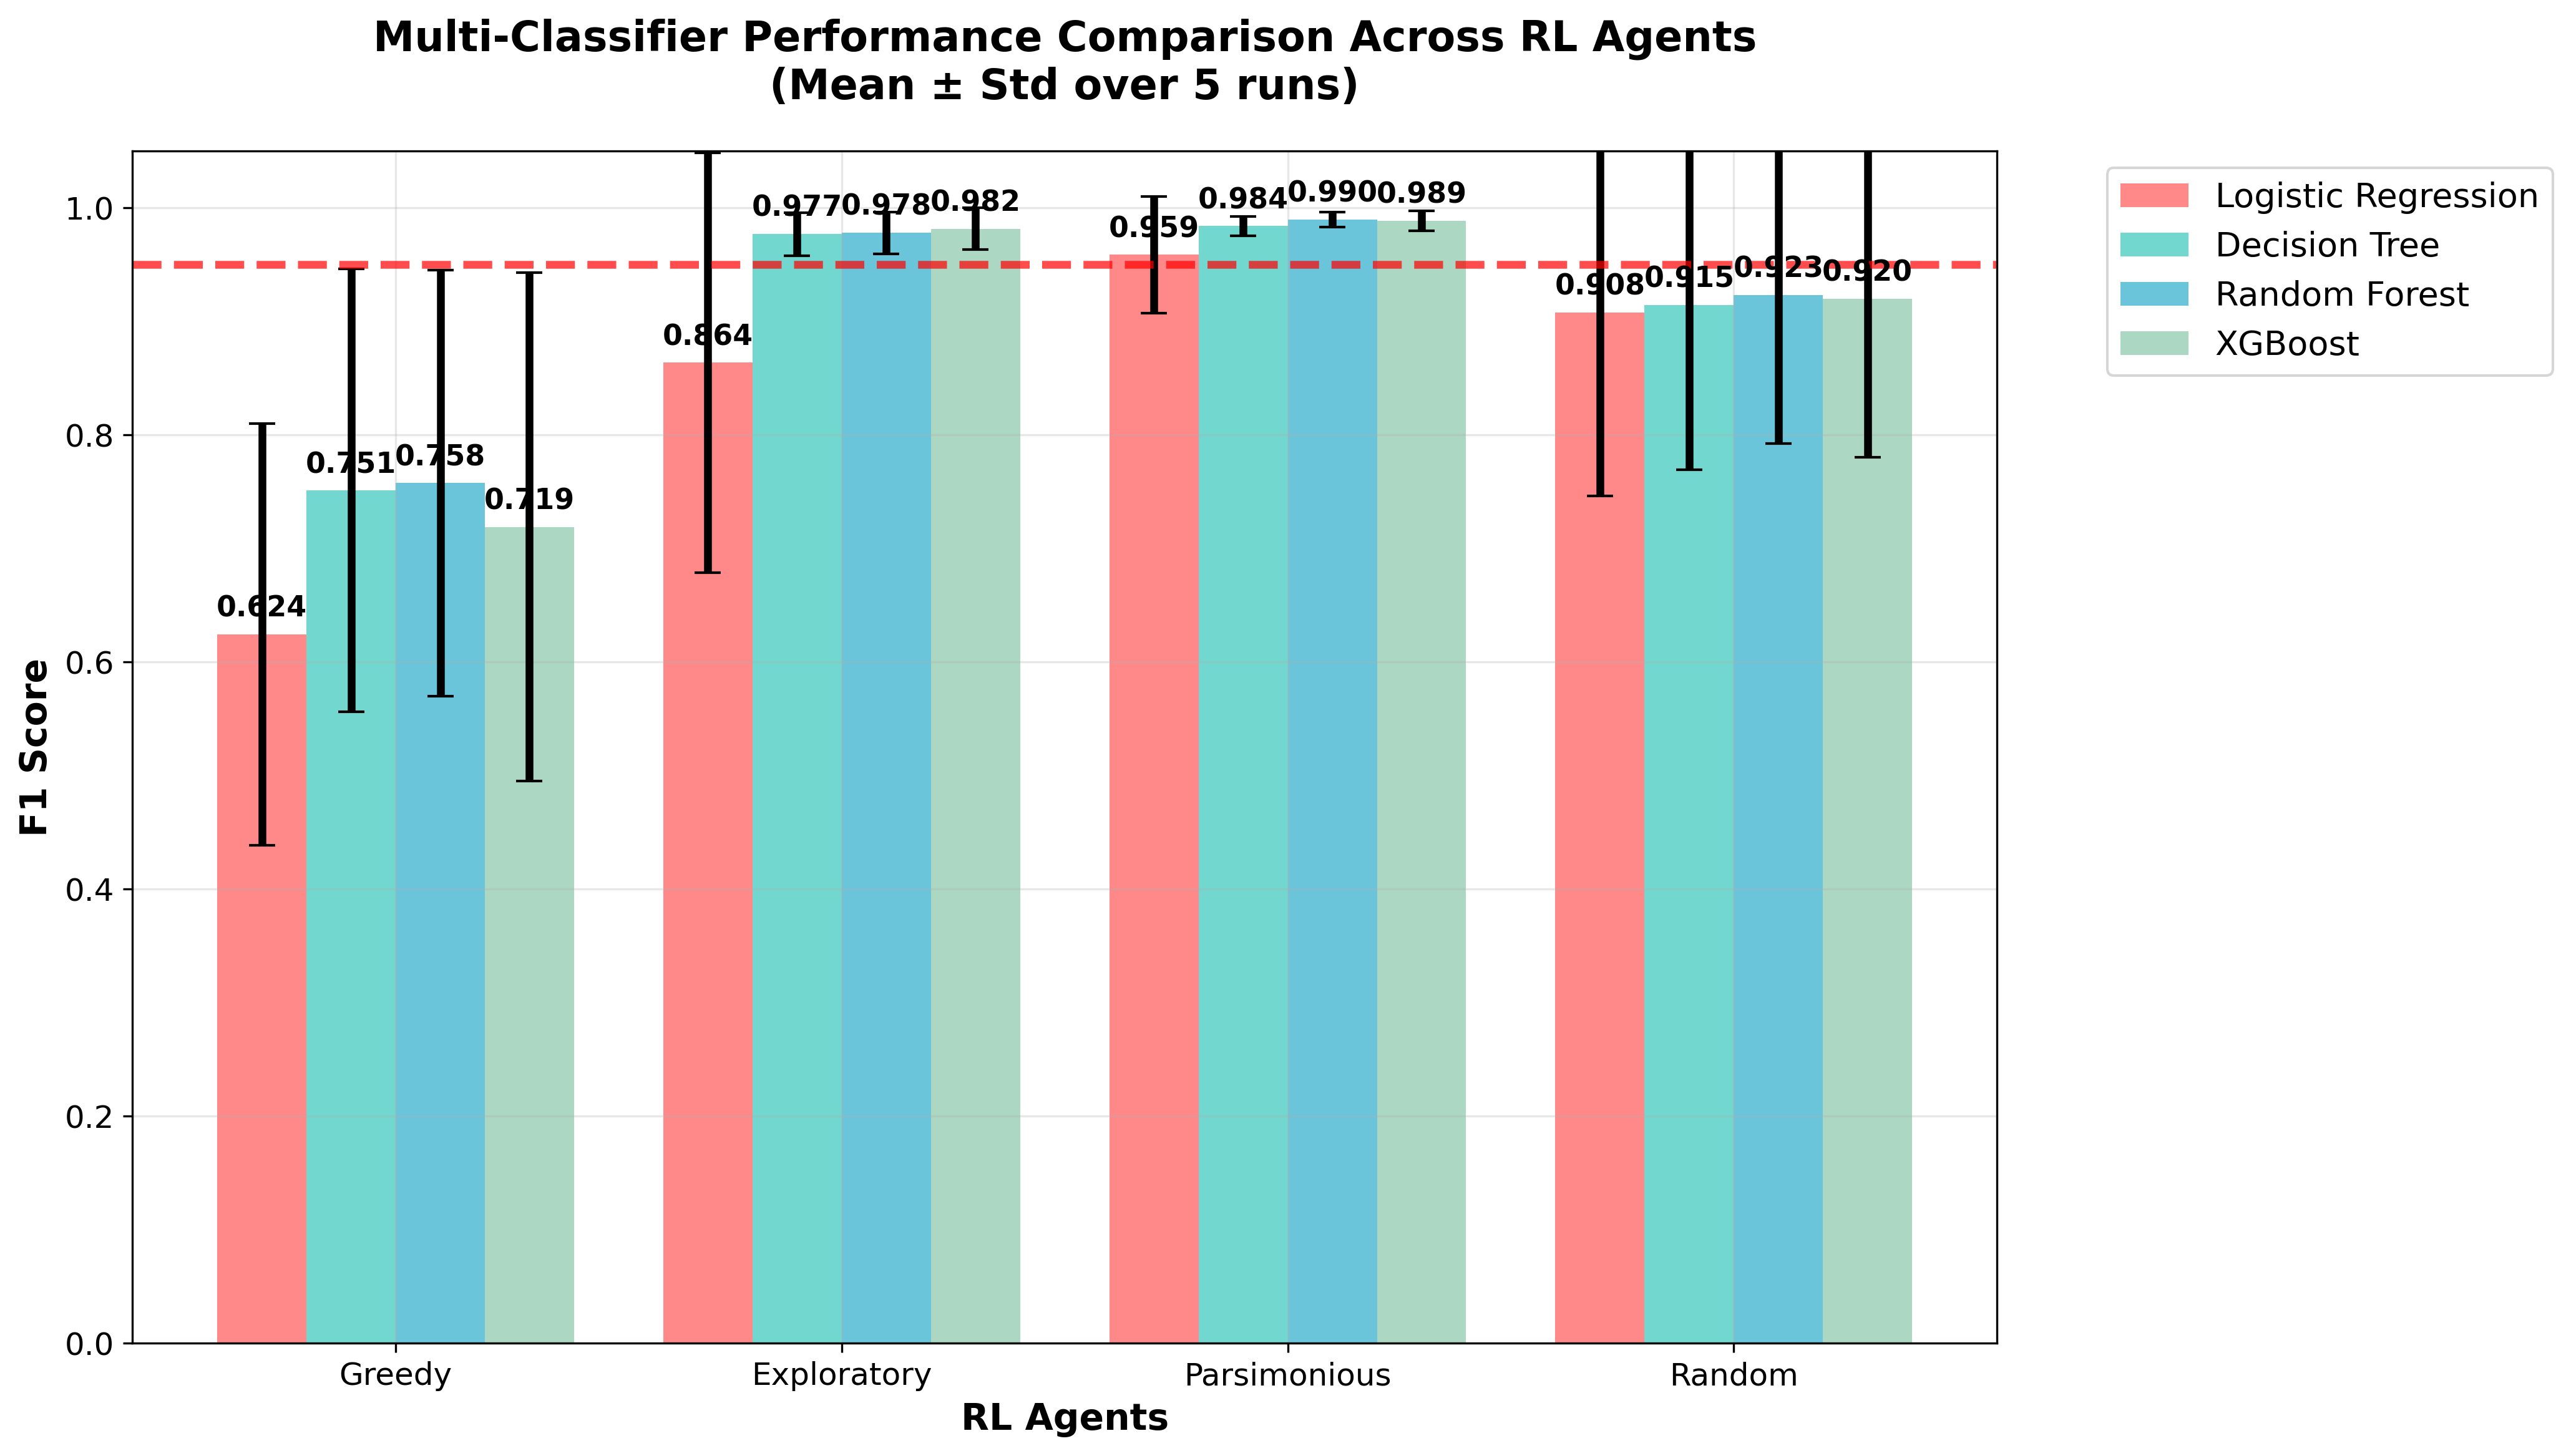




--- 2_feature_selection_efficiency.png ---


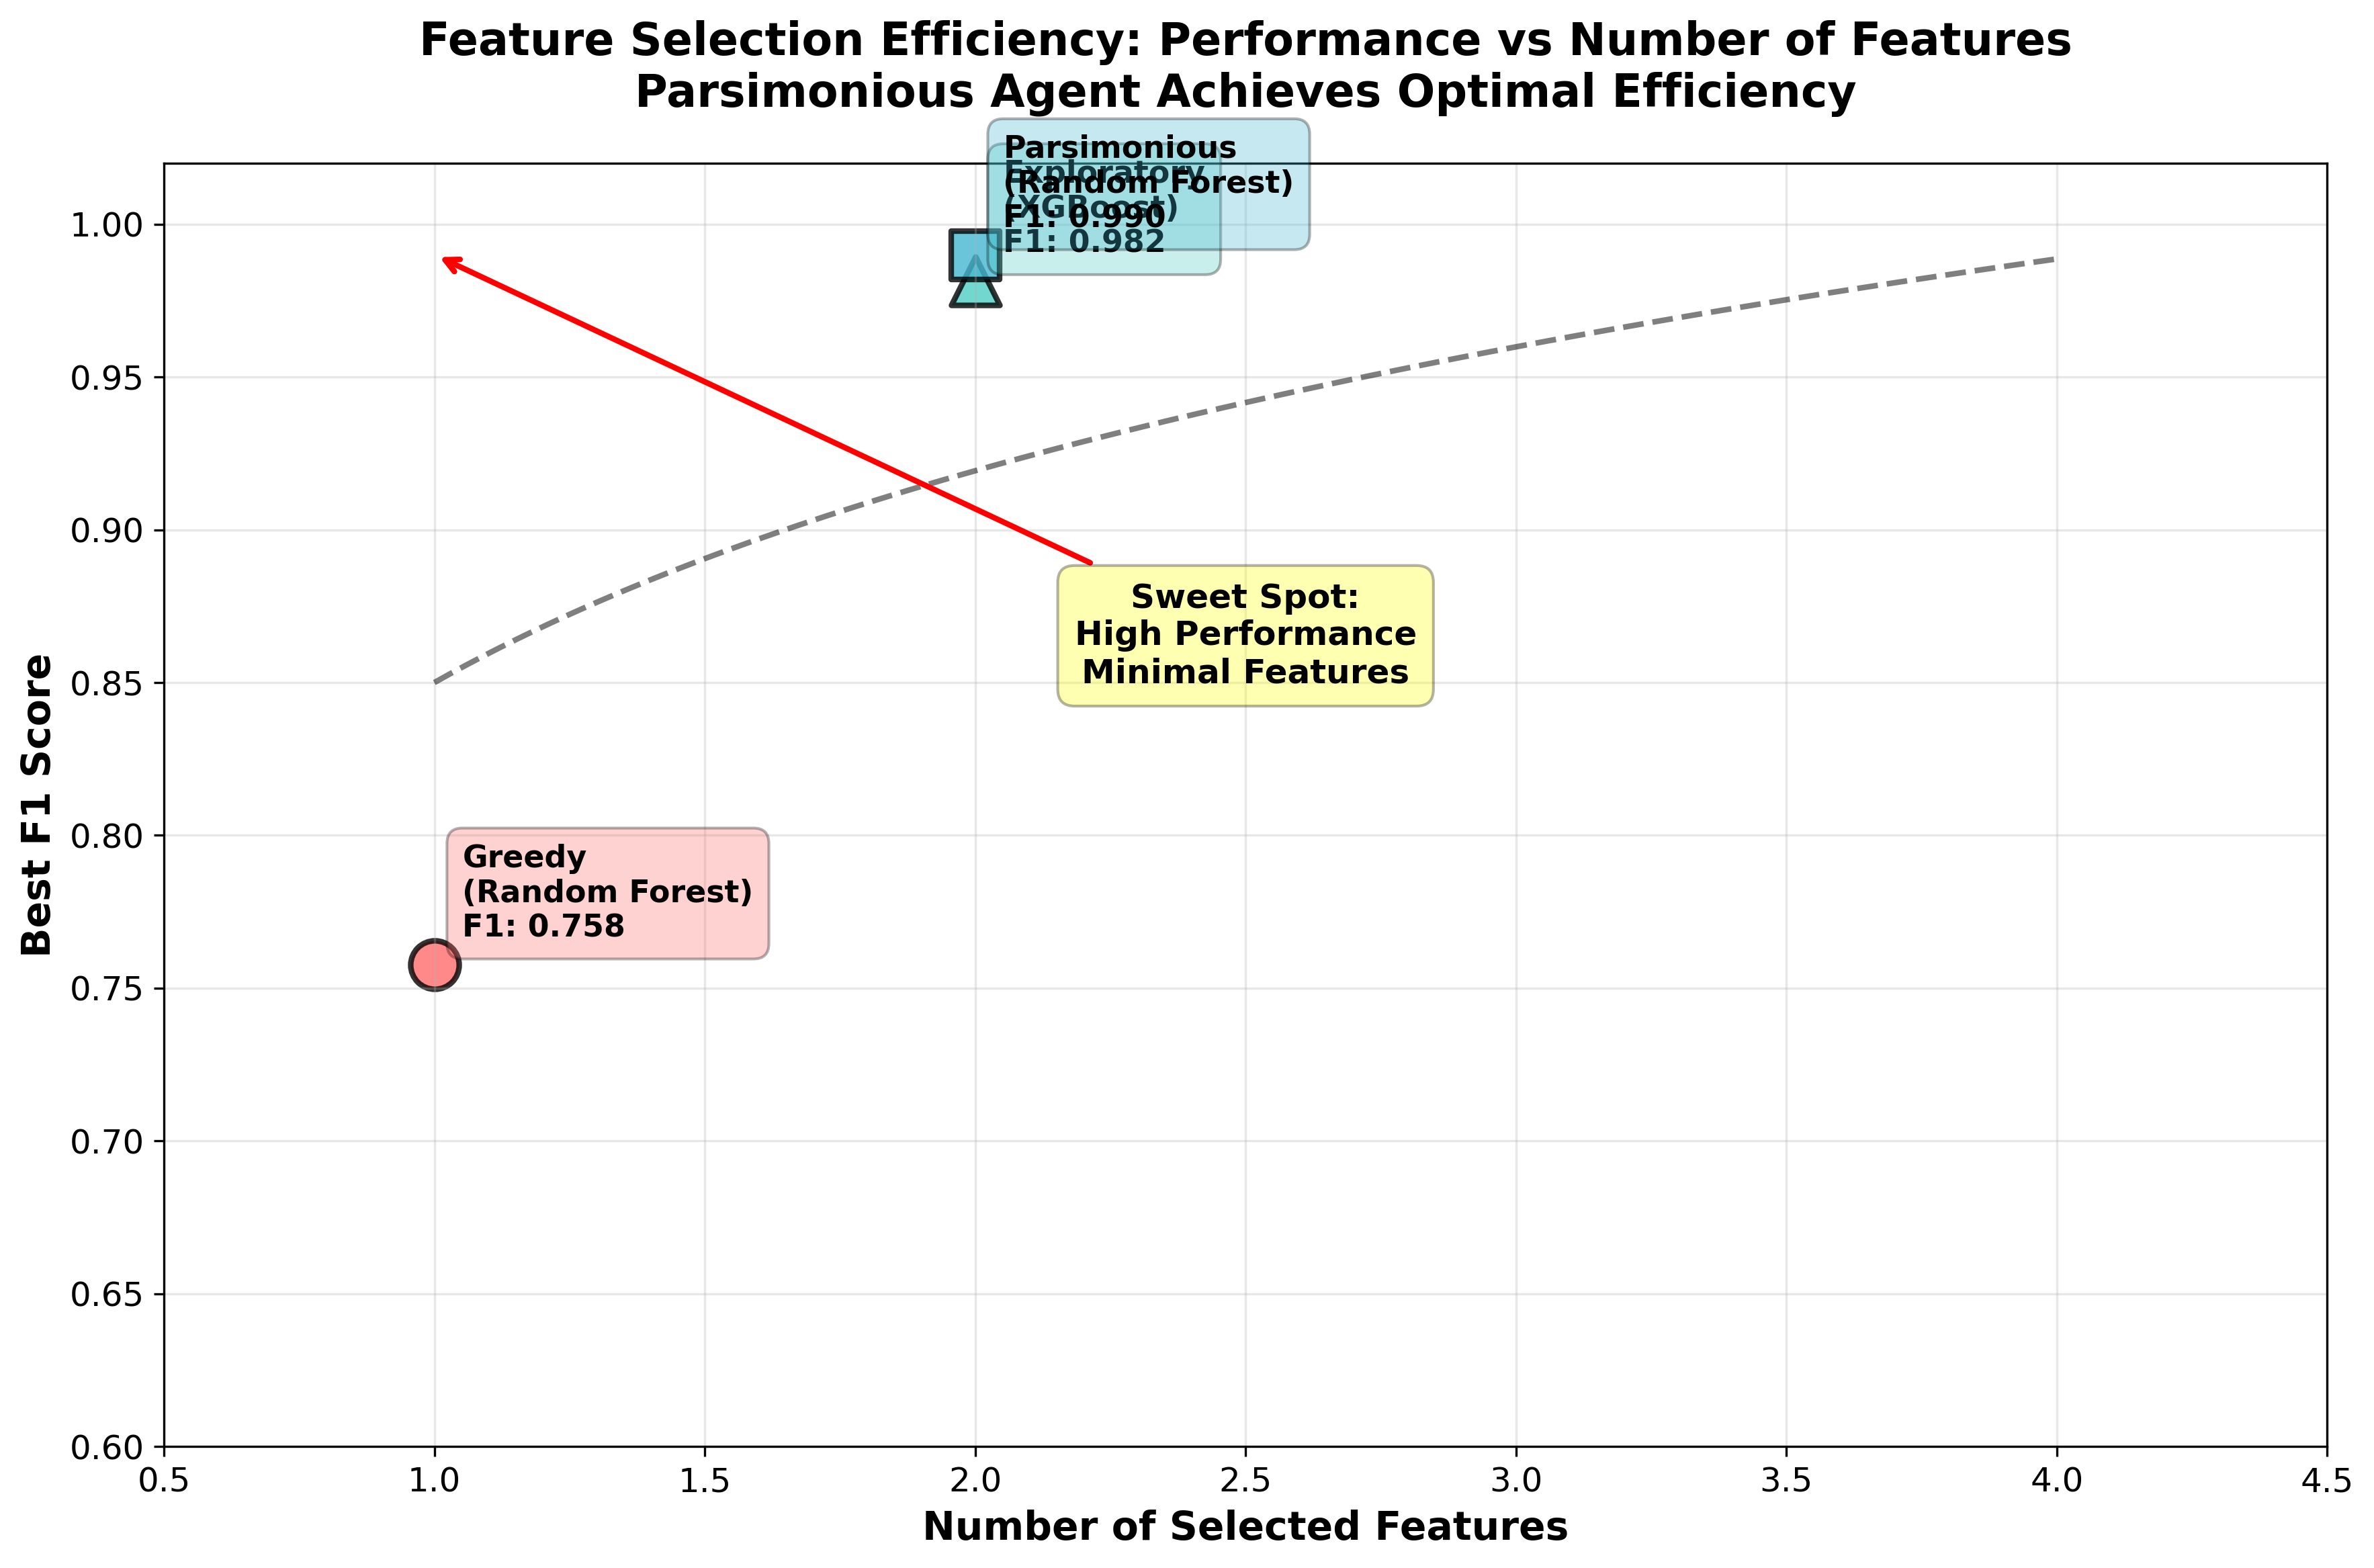




--- 3_feature_selection_patterns.png ---


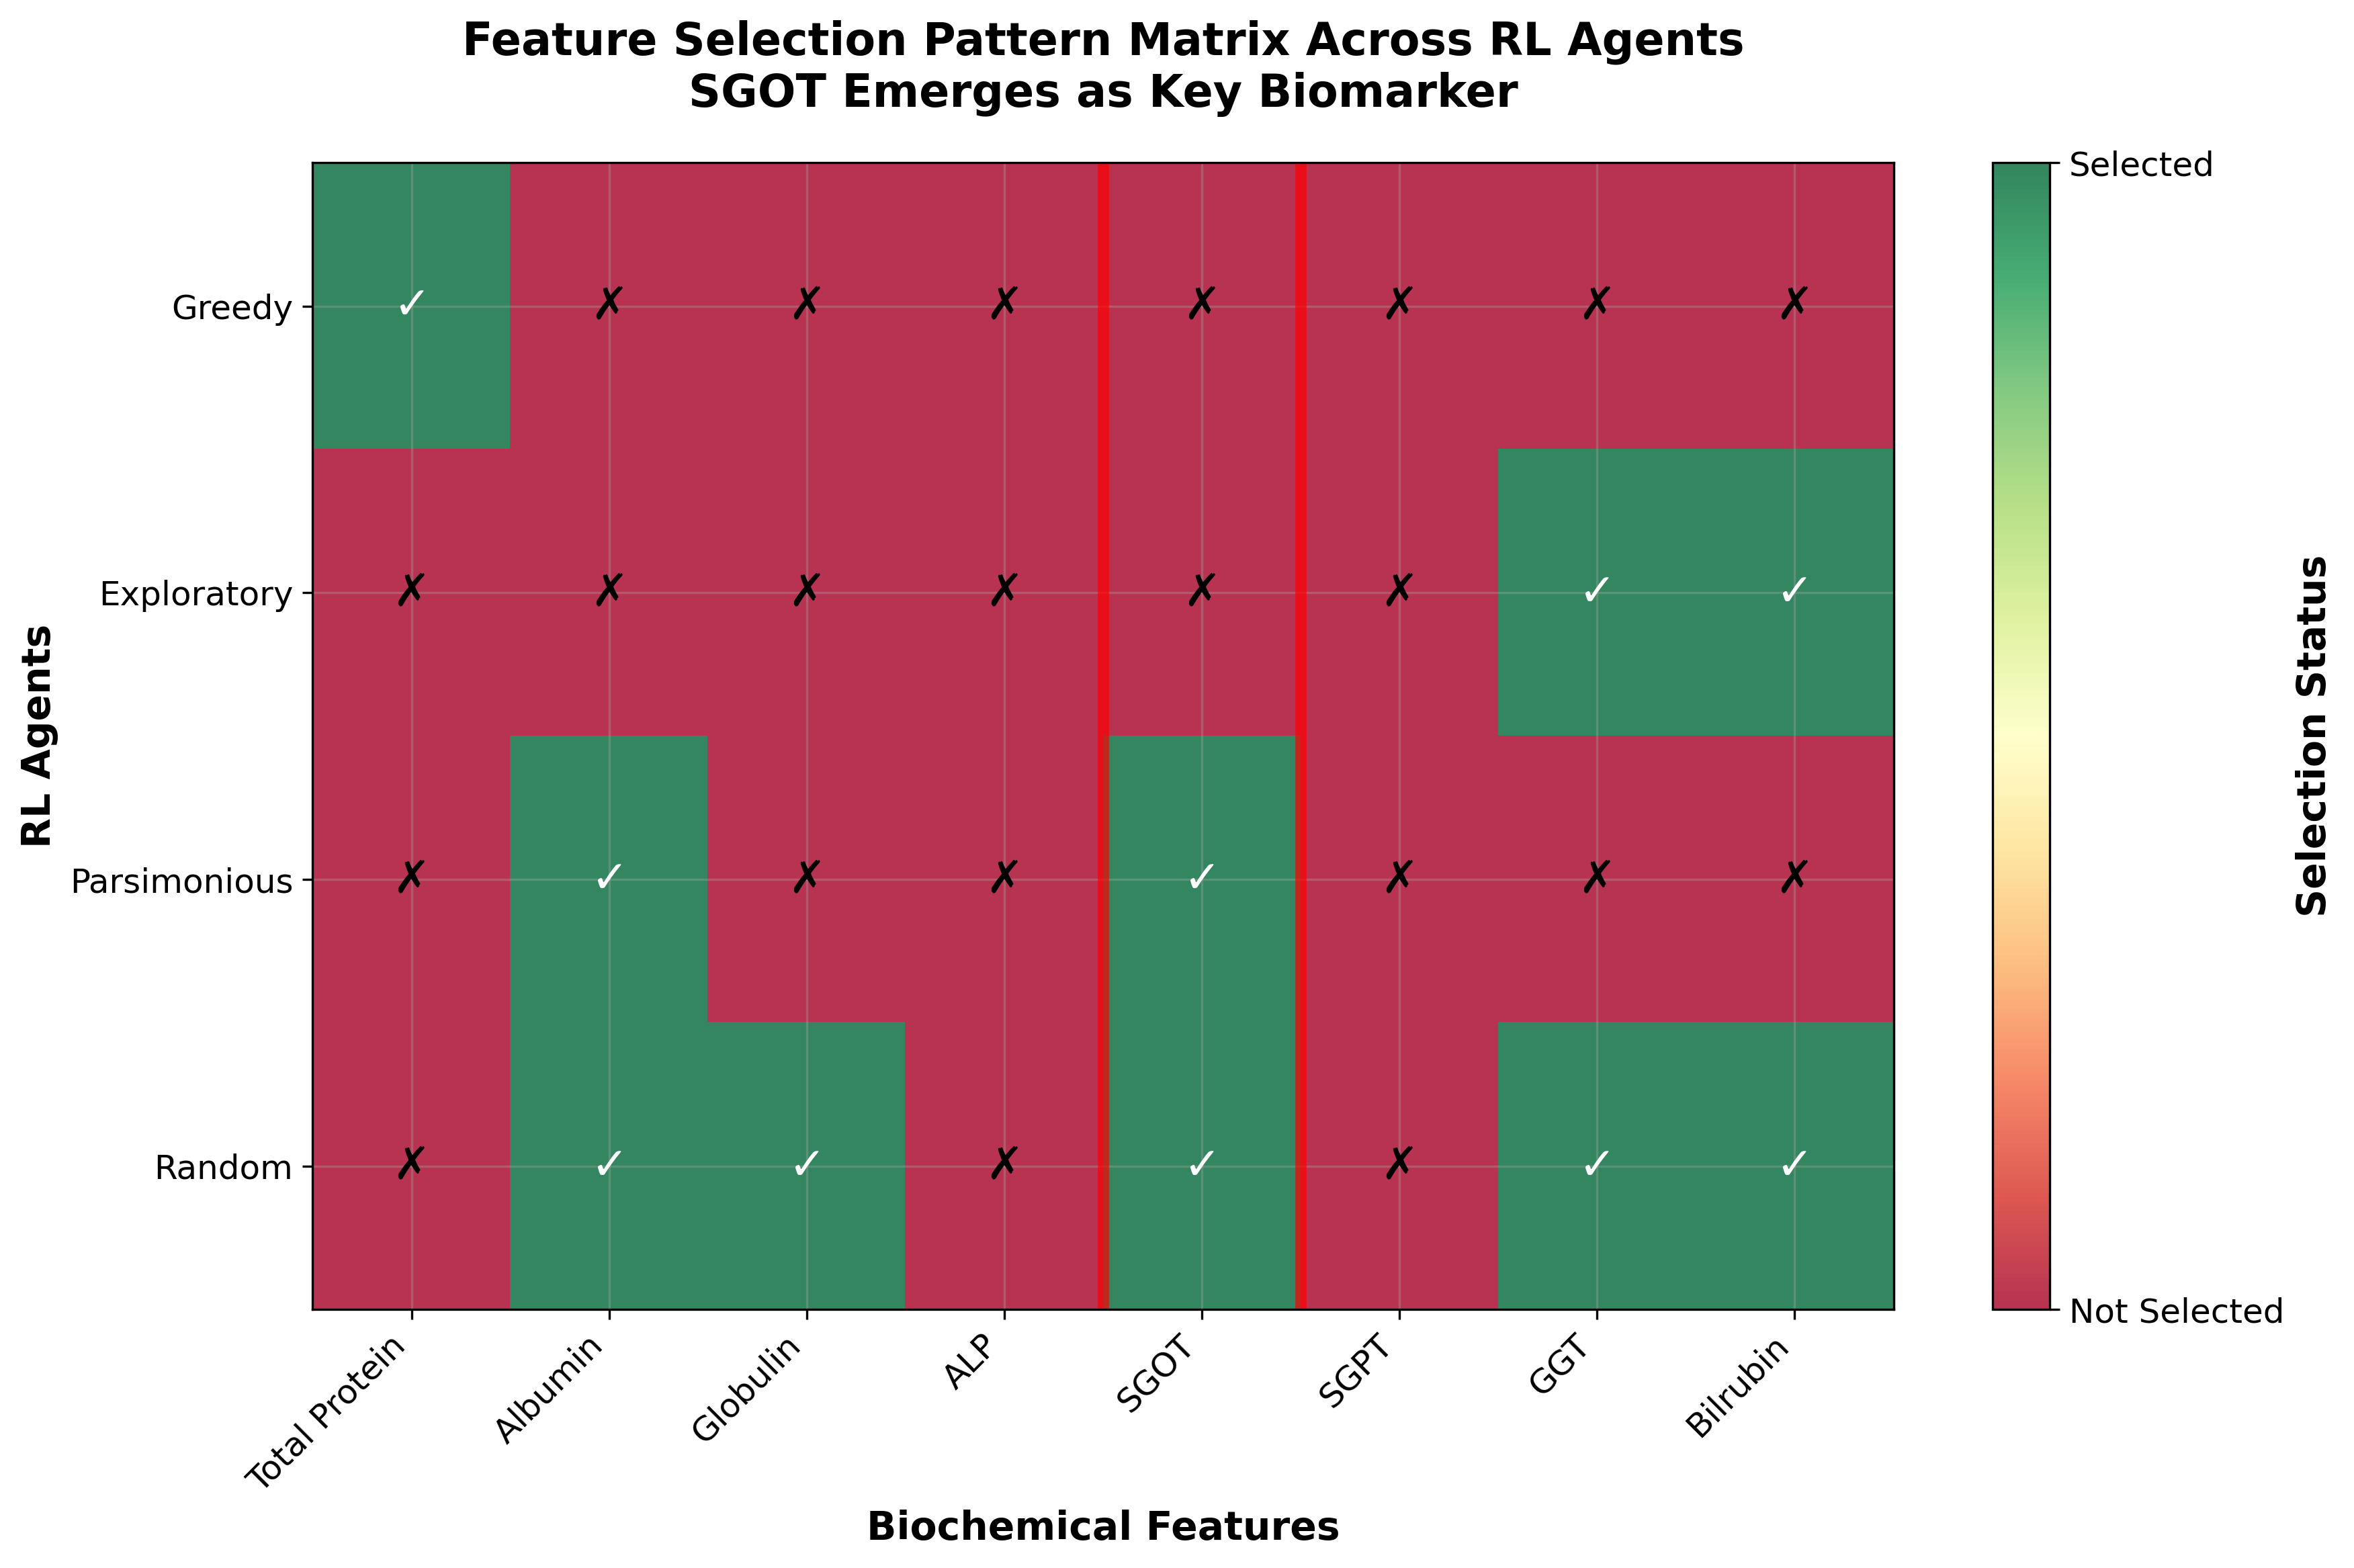




--- 4_statistical_robustness.png ---


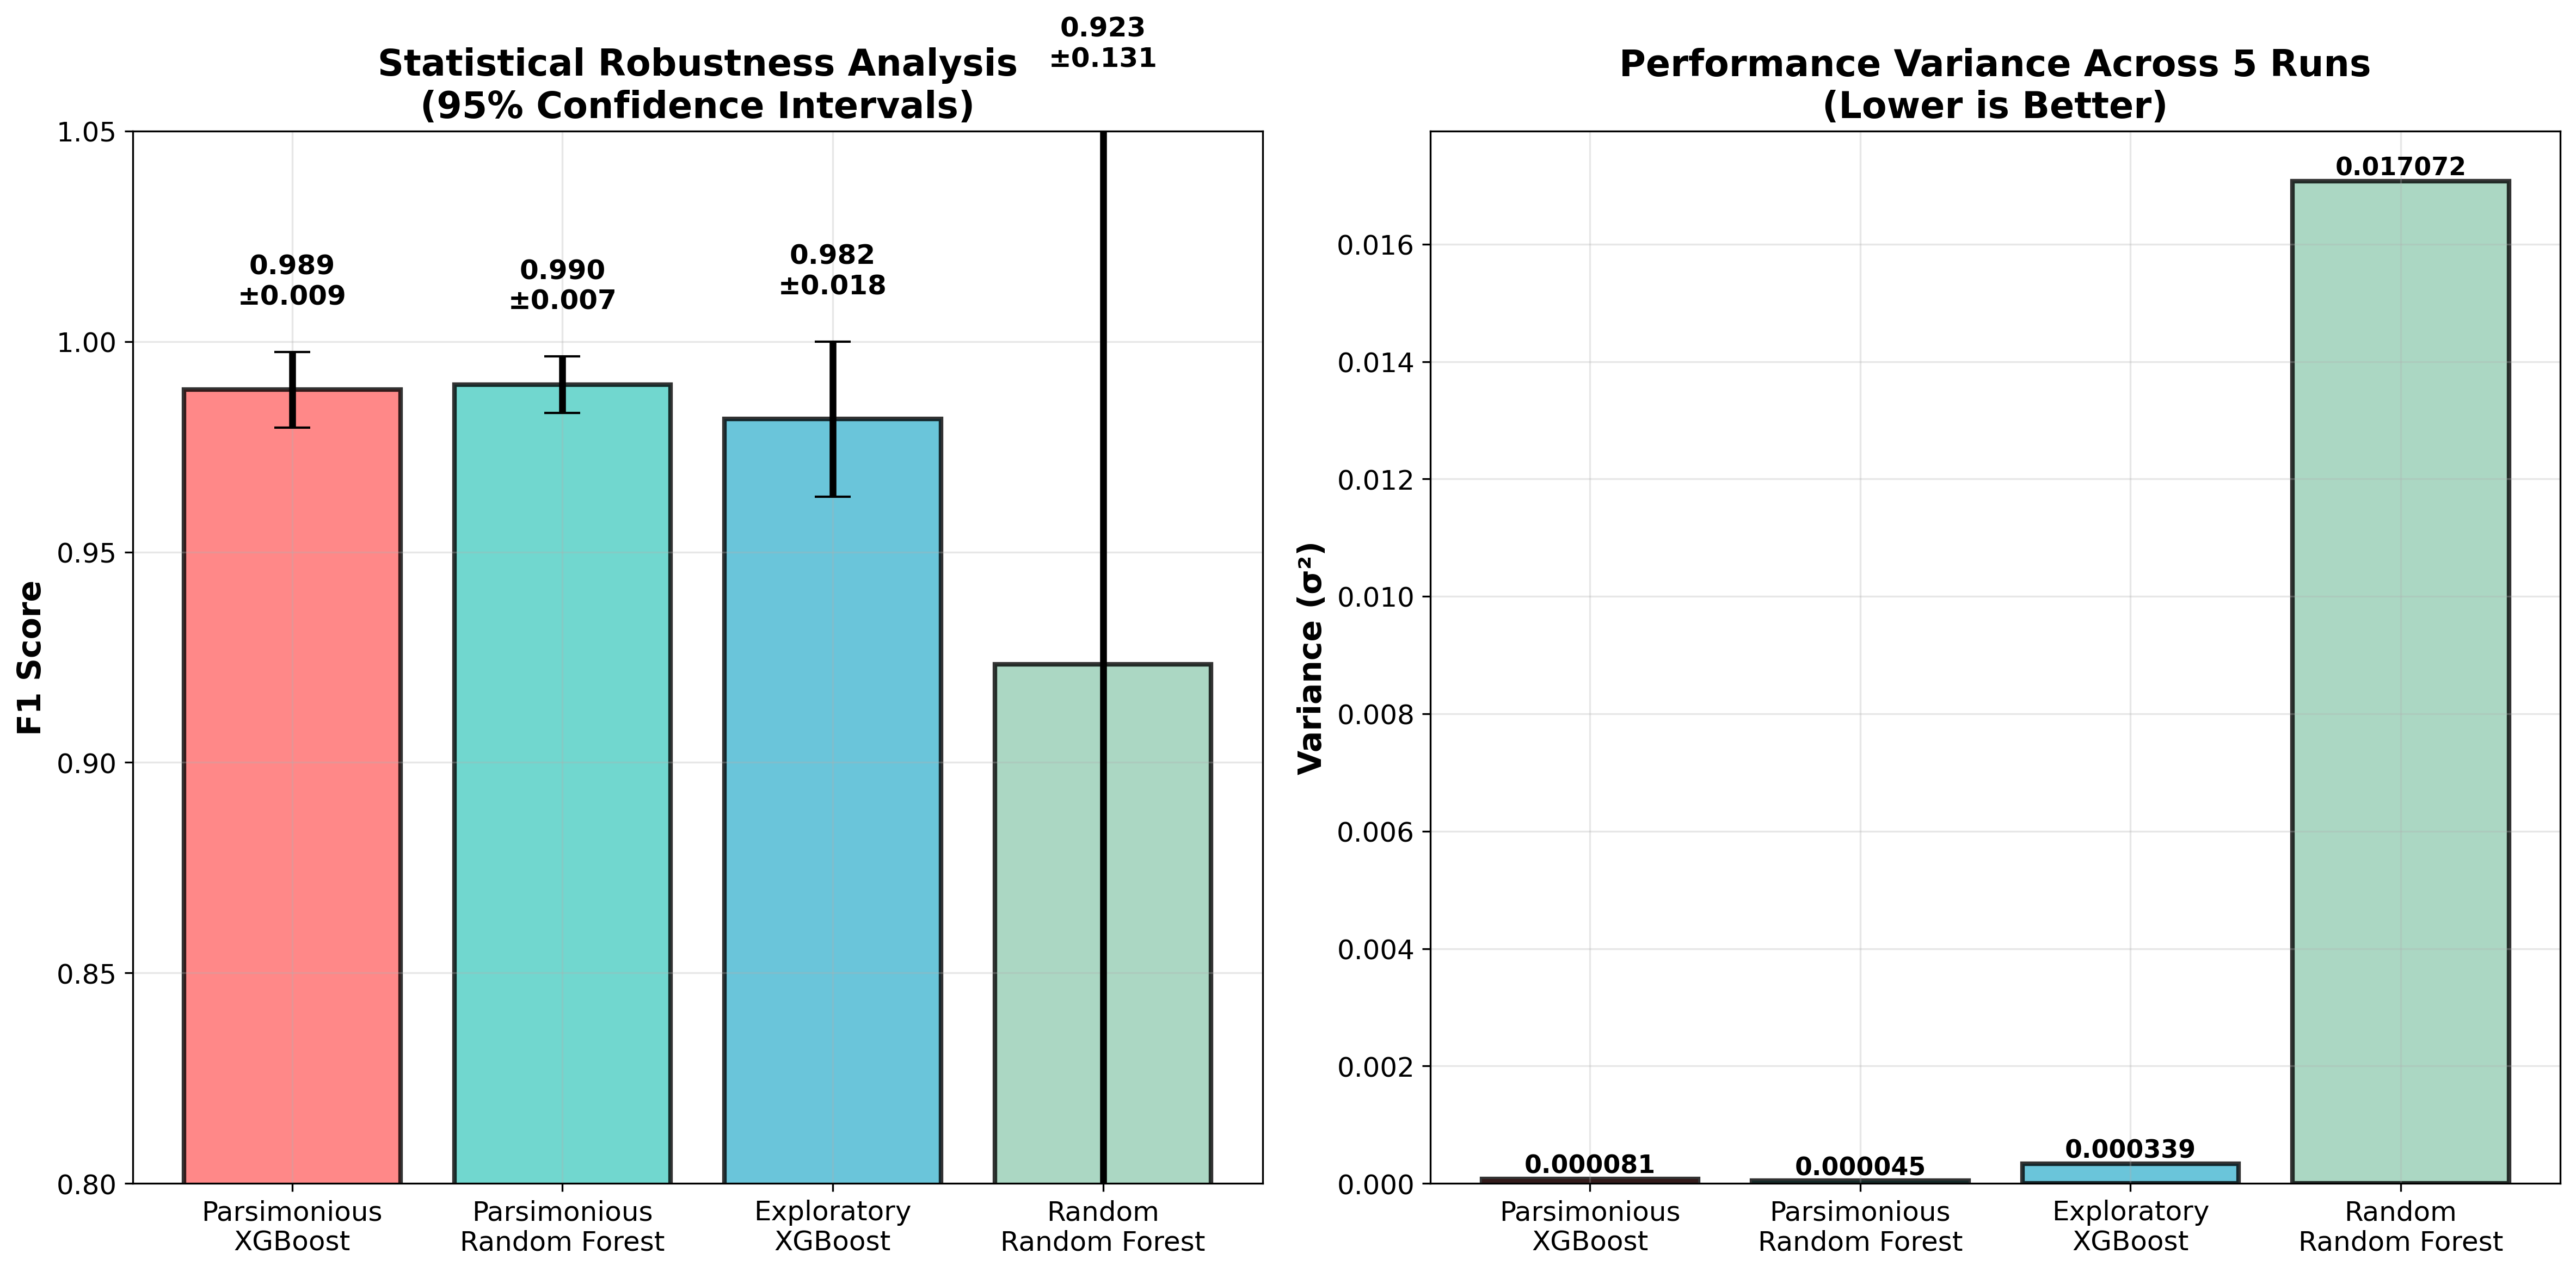




--- 5_linear_vs_nonlinear.png ---


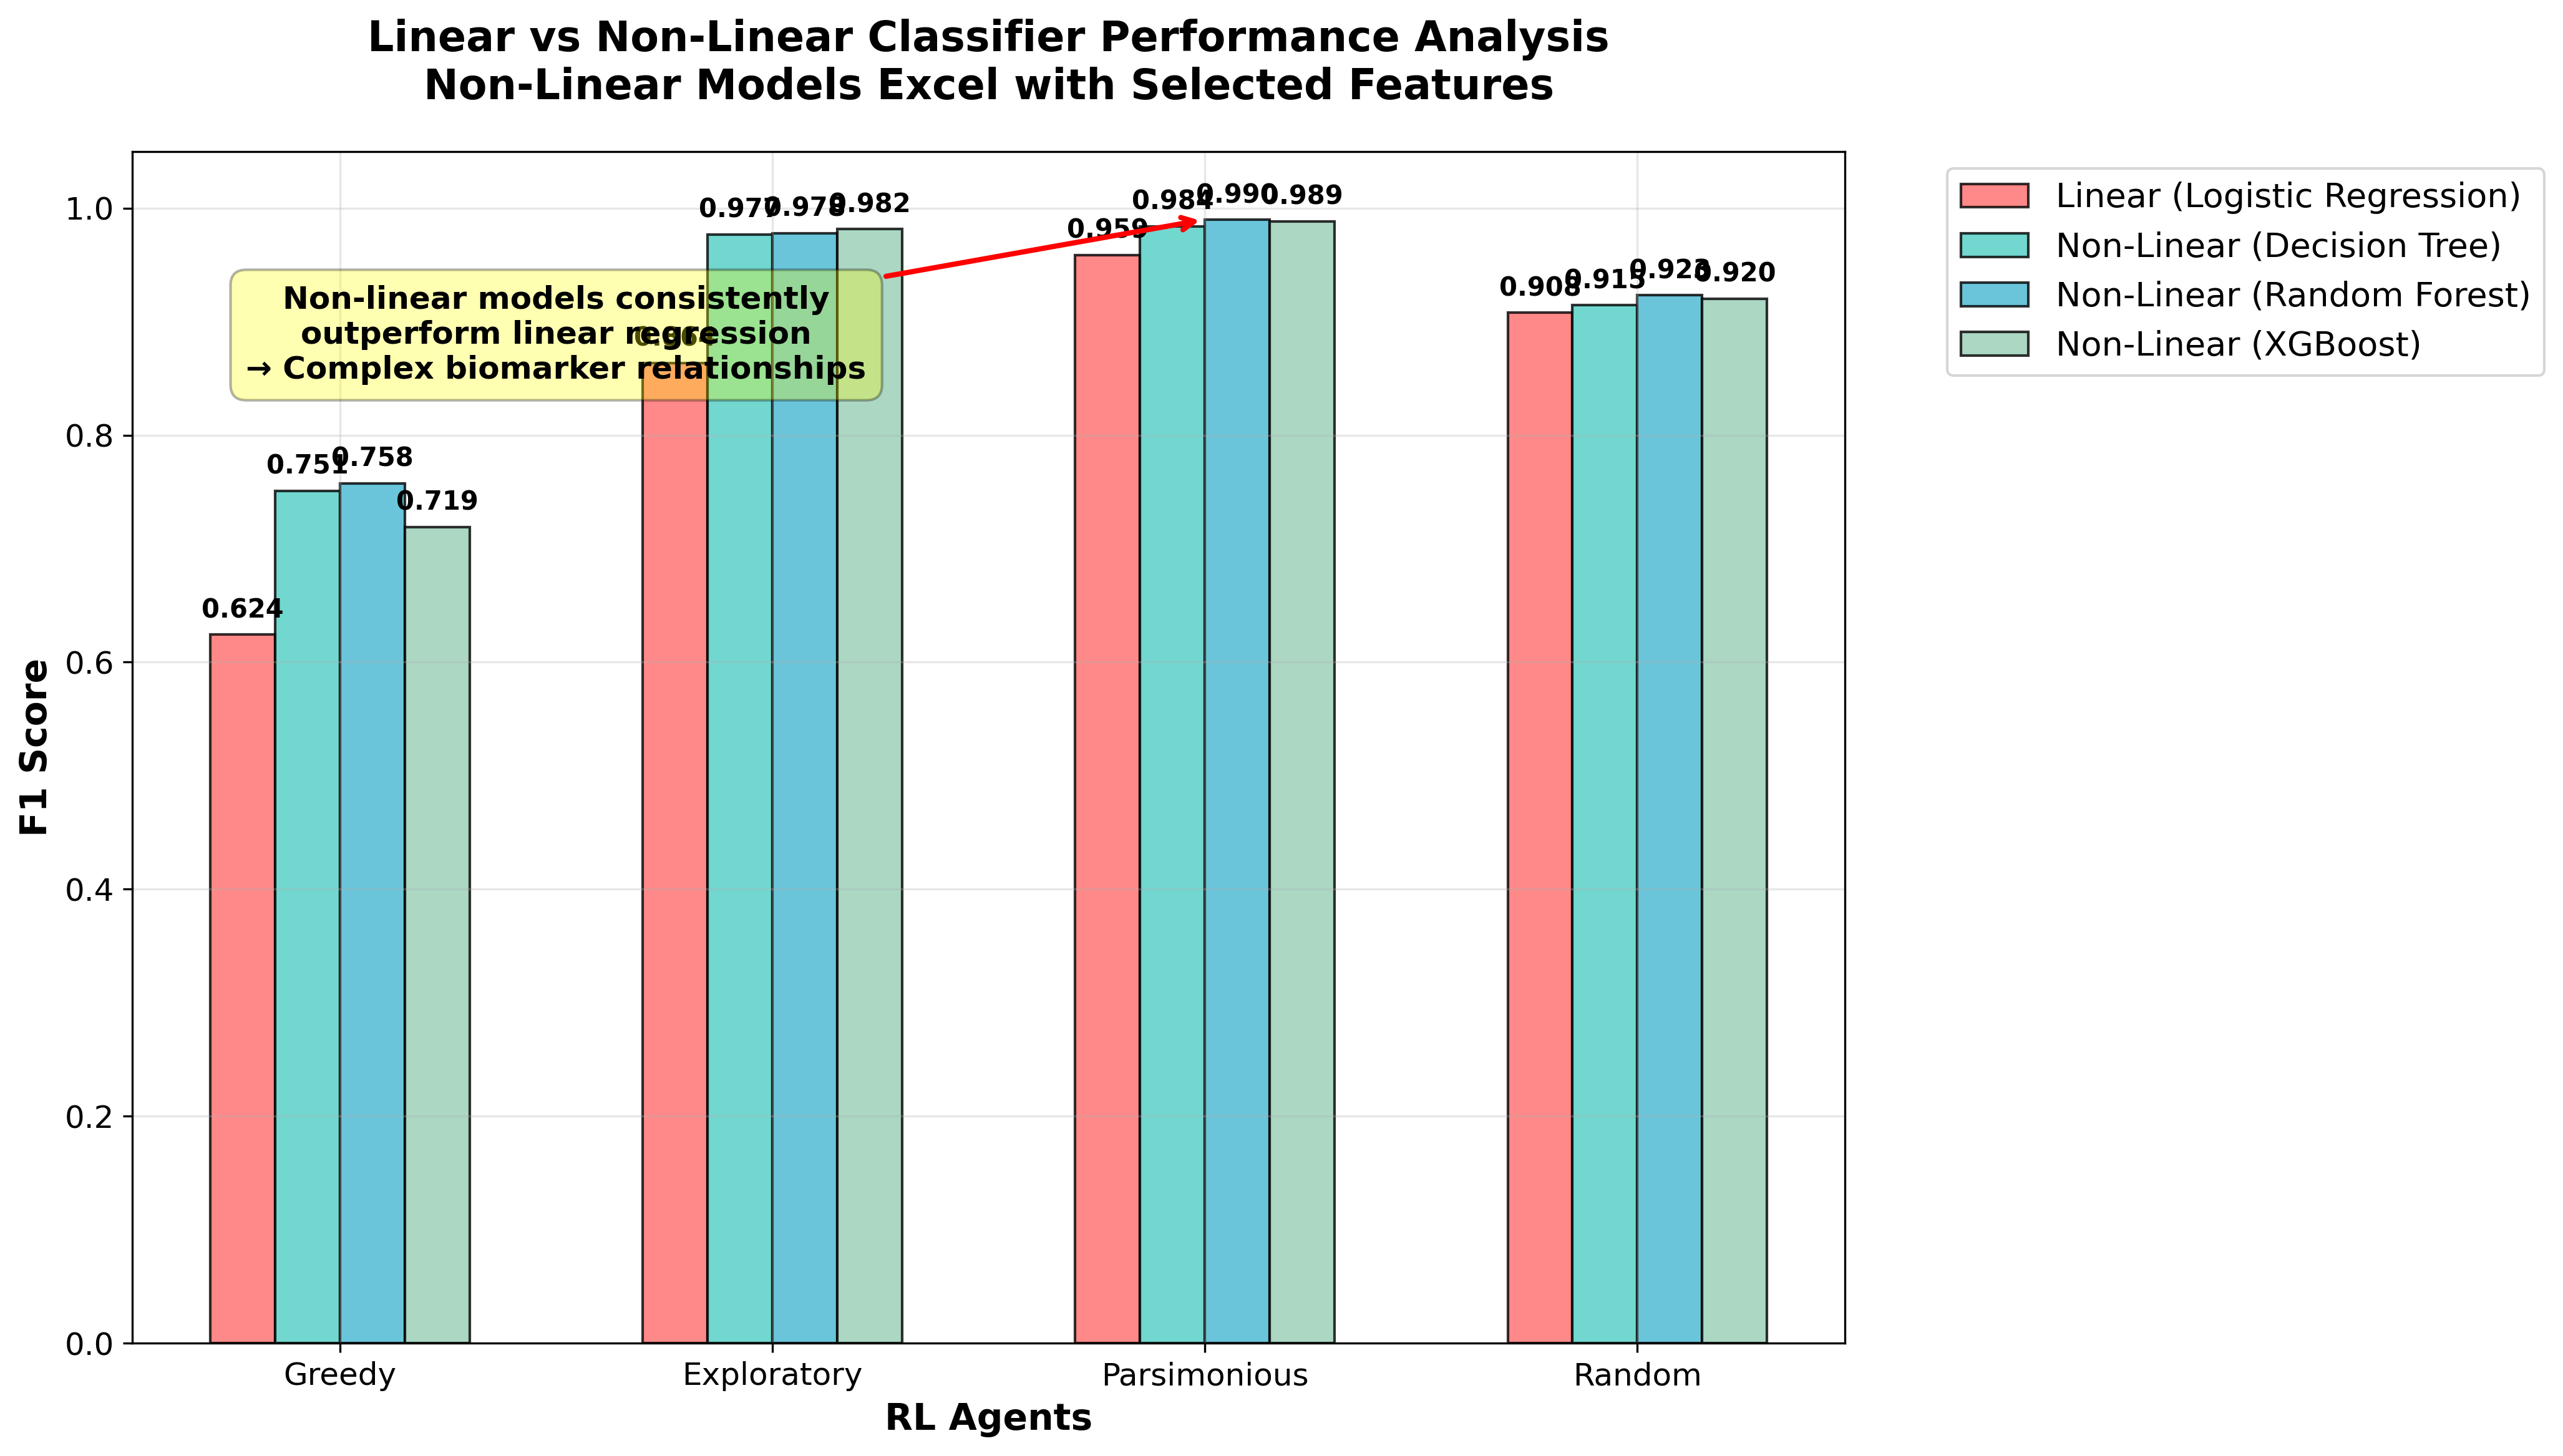

In [ ]:
import os
from IPython.display import Image, display

output_dir = 'final_plots_multi_classifier'

print(f"Displaying plots from: {output_dir}/")

plot_files = sorted([f for f in os.listdir(output_dir) if f.endswith('.png')])

if not plot_files:
    print(f"No PNG files found in {output_dir}.")
else:
    for plot_file in plot_files:
        file_path = os.path.join(output_dir, plot_file)
        print(f"\n--- {plot_file} ---")
        display(Image(filename=file_path))
        print("\n")


✅ Successfully loaded results from saved_models/hcv_rl_multirun_5runs_cpu.pkl


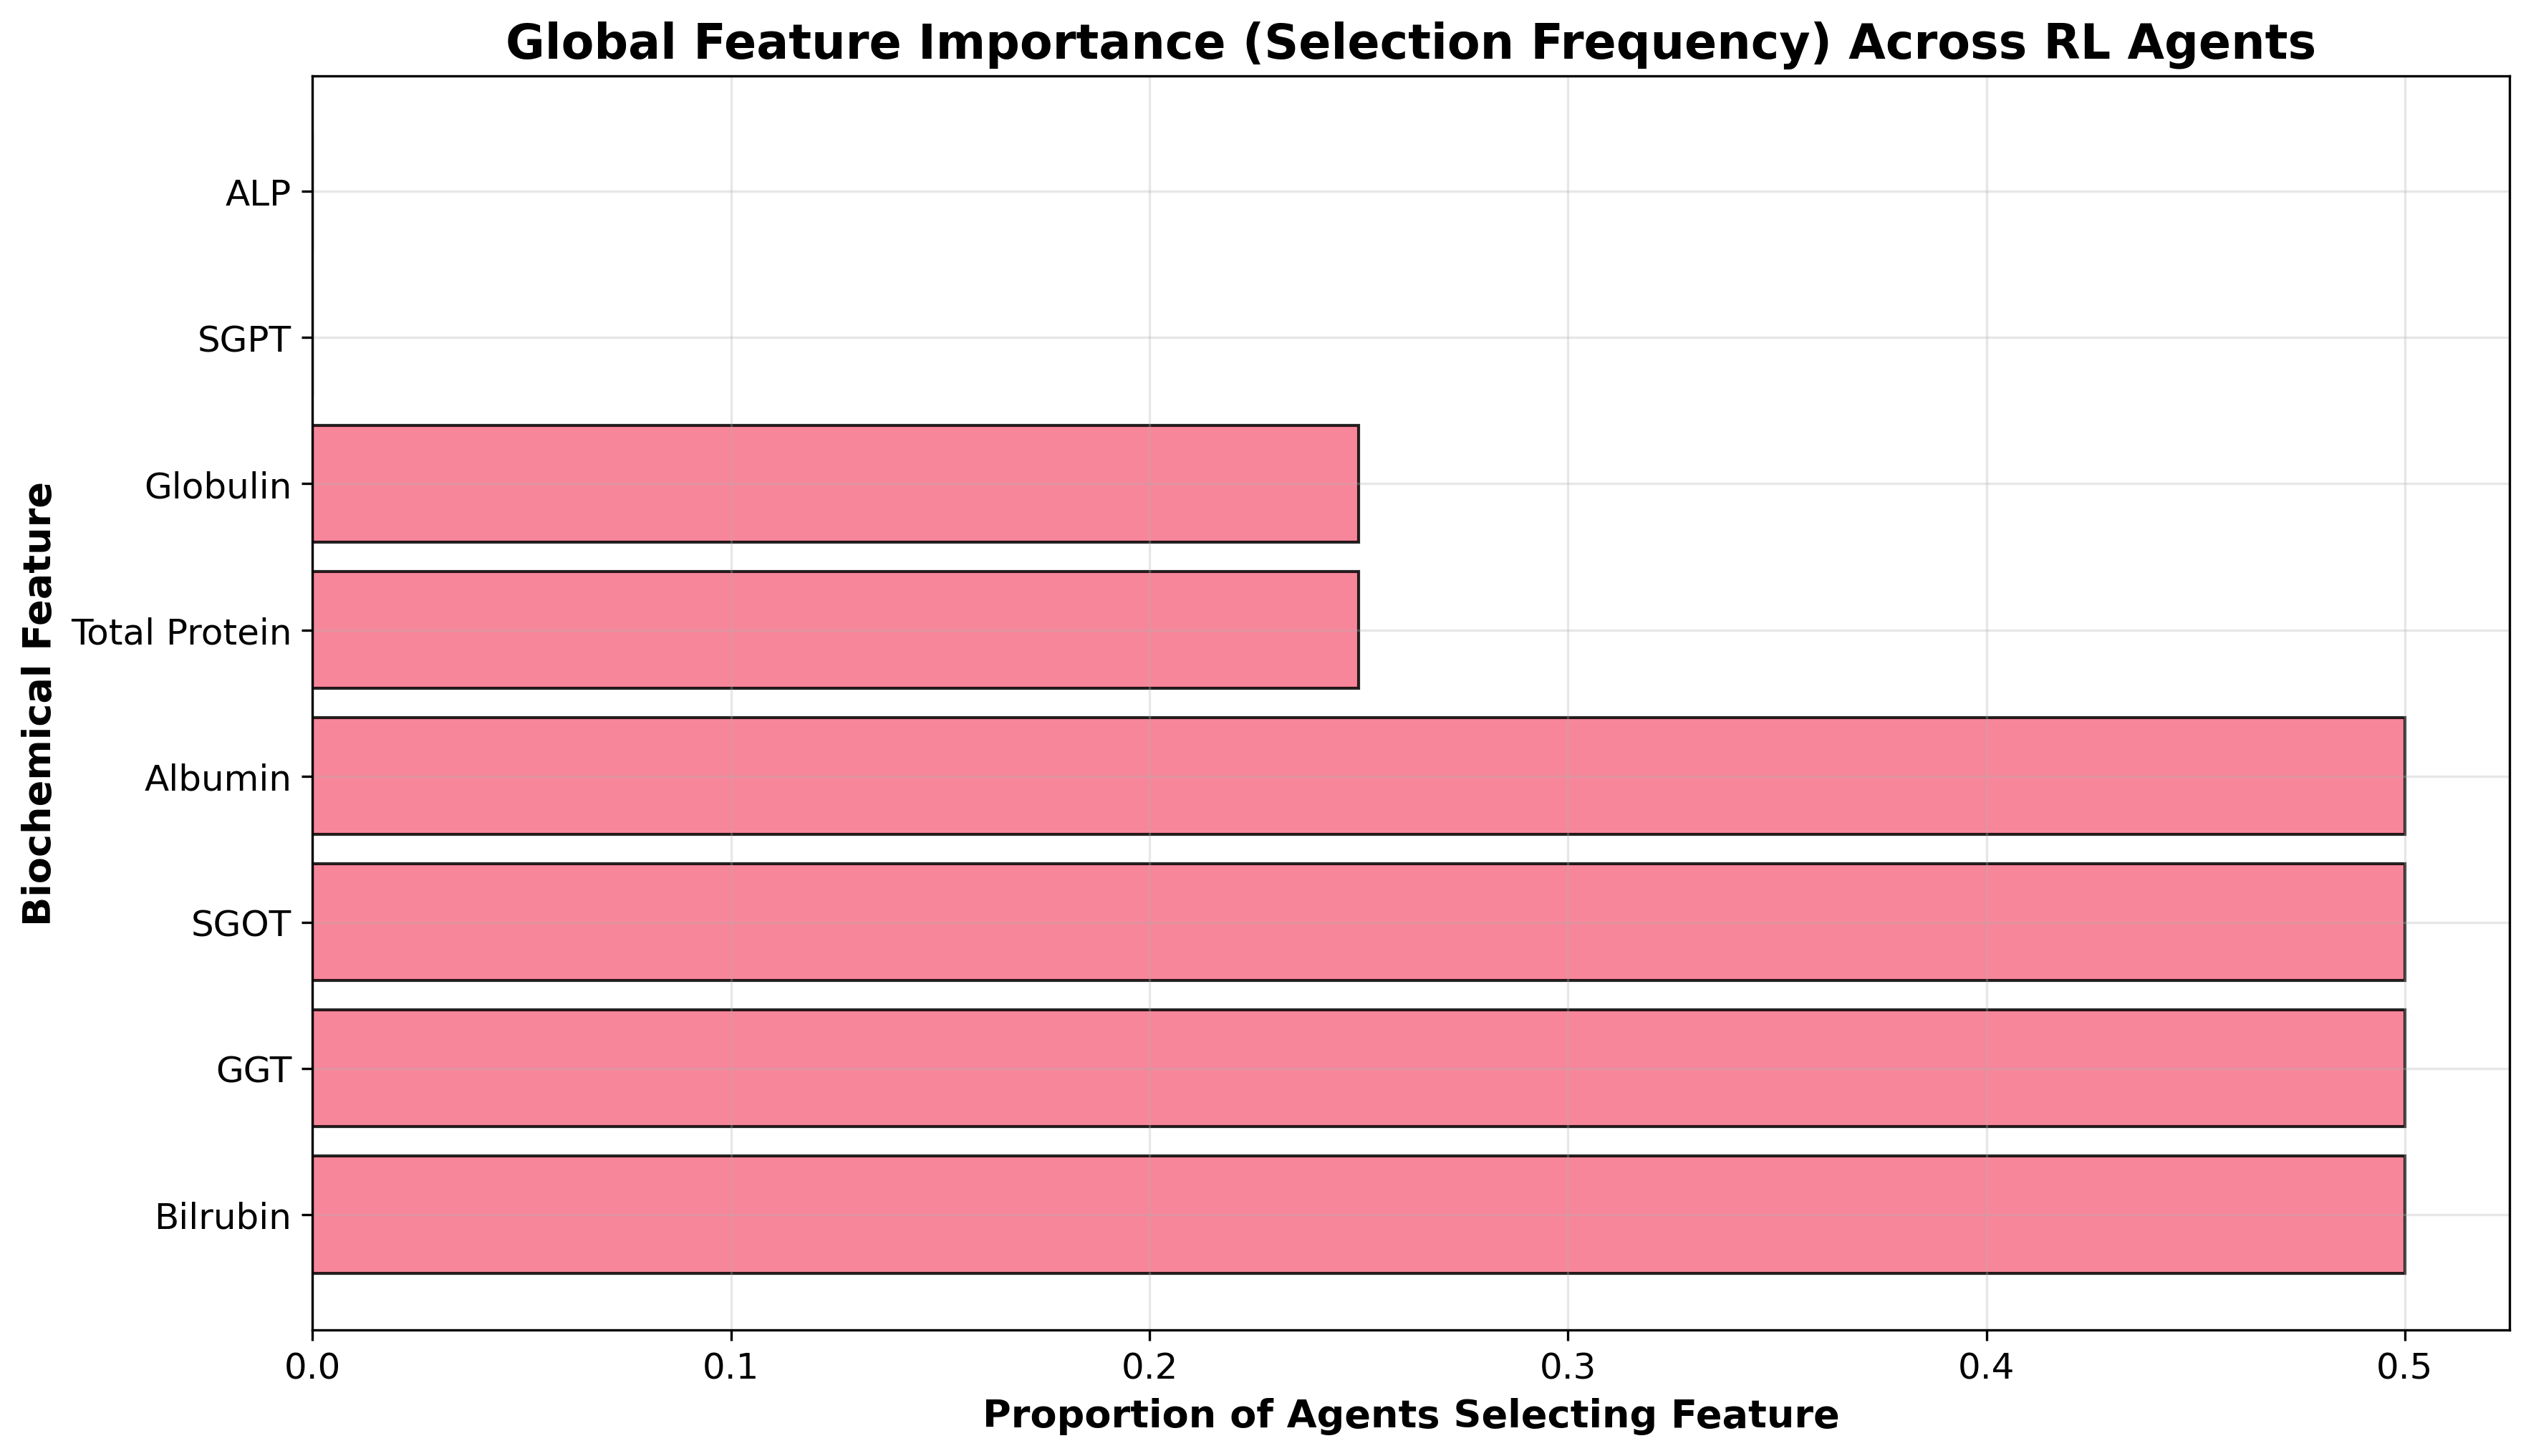

📊 Plot 7: Global Feature Importance - Saved!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os
from collections import defaultdict

# Define the path to the cached results file (ensure this matches your execution)
results_file = 'hcv_rl_multirun_5runs_cpu.pkl'
cached_file_path = os.path.join('saved_models', results_file)

# Load the results
try:
    with open(cached_file_path, 'rb') as f:
        data = pickle.load(f)
    averaged_results = data['averaged_results']
    features = data['features'] # The master list of all possible features
    print(f"✅ Successfully loaded results from {cached_file_path}")
except FileNotFoundError:
    print(f"❌ Error: Cached results file not found at {cached_file_path}. Please ensure the main pipeline ran successfully.")
    averaged_results = {}
    features = []


if averaged_results and features:
    # Calculate feature selection frequencies
    # Count how many agents selected each feature
    feature_counts = defaultdict(int)
    total_agents = 0
    for agent_name in averaged_results:
        total_agents += 1
        selected_by_agent = averaged_results[agent_name].get('features', [])
        for feature in selected_by_agent:
            if feature in features: # Ensure it's a valid feature from the master list
                feature_counts[feature] += 1

    # Convert counts to frequencies (proportion of agents that selected the feature)
    # Ensure we don't divide by zero if no agents were found
    frequencies = [feature_counts[f] / total_agents if total_agents > 0 else 0 for f in features]

    # Plot 7: Global Feature Selection Importance
    plt.figure(figsize=(12, 7))

    # Sort features by frequency for better visualization
    sorted_indices = np.argsort(frequencies)
    sorted_features = [features[i] for i in sorted_indices]
    sorted_frequencies = [frequencies[i] for i in sorted_indices]

    plt.barh(sorted_features, sorted_frequencies, edgecolor='black', alpha=0.85)
    plt.gca().invert_yaxis() # Invert y-axis to have the most frequent at the top

    plt.title('Global Feature Importance (Selection Frequency) Across RL Agents', fontsize=16, fontweight='bold')
    plt.xlabel('Proportion of Agents Selecting Feature', fontsize=13, fontweight='bold')
    plt.ylabel('Biochemical Feature', fontsize=13, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()

    output_dir = 'final_plots_multi_classifier'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/7_global_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Plot 7: Global Feature Importance - Saved!")
else:
    print("⚠️ Cannot generate Plot 7: Averaged results or features are not available.")